# Exucitive summary 
basicly the project intention is to predict the winning team in a Moba Game called Dota that incloude matches combining 10 players 5 for each team, in each team must pick a variation of heroes that have diffrent types and attack types such as range or melee. the target audiance is fans, sponsers and teams along with dota match making to reveal to them if there is an embalance in the match making. using the start match hero pick combinations and additional hero information along with basic match information like Average Rank. the prediction must be made on data collected in the start of the match, in addition to recomending hero types and attack types combinations that frequently win matches. to achieve that two approuches ware created to group the data by match teams and whole team in one obbservation, then modeling the two approuches and evaluate the models. all details are mentioned in the seperate third step report

## importing needed libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime

plt.style.use('fivethirtyeight')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Munging

In [4]:
# loading the queried match data set
df = pd.read_csv('data-28.csv')
df.head()

FileNotFoundError: File b'data-28.csv' does not exist

In [6]:
# checking the shape
df.shape

(200000, 22)

In [7]:
# making sure the types are correctly formatted
df.dtypes

match_id            int64
player_slot         int64
hero_id             int64
match_id.1          int64
match_seq_num       int64
radiant_win          bool
start_time          int64
duration            int64
avg_mmr             int64
num_mmr             int64
lobby_type          int64
game_mode           int64
avg_rank_tier     float64
num_rank_tier     float64
cluster           float64
id                  int64
name               object
localized_name     object
primary_attr       object
attack_type        object
roles              object
legs                int64
dtype: object

##### seams like the attribute types are correct, only the start time is registered in seconds using integer value and need to be converted to  a date and time object

In [8]:
# displaying the columns summary stats
df.describe()

,match_id,player_slot,hero_id,match_id.1,match_seq_num,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,id,legs
count,2.000000e+05,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,0.0,0.0,0.0,200000.000000,200000.000000
mean,3.300473e+09,66.000000,48.844190,3.300473e+09,2.881480e+09,1.499513e+09,2527.770600,3120.458300,3.832400,4.618050,15.930450,NaN,NaN,NaN,48.844190,2.024940
std,2.626862e+05,64.015783,33.129621,2.626862e+05,2.104697e+05,7.631554e+03,674.015061,929.816874,1.798479,3.503102,8.861738,NaN,NaN,NaN,33.129621,1.018638
min,3.300000e+09,0.000000,1.000000,3.300000e+09,2.881046e+09,1.499498e+09,361.000000,44.000000,2.000000,0.000000,2.000000,NaN,NaN,NaN,1.000000,0.000000
25%,3.300242e+09,2.000000,19.000000,3.300242e+09,2.881296e+09,1.499506e+09,2093.000000,2527.000000,2.000000,0.000000,4.000000,NaN,NaN,NaN,19.000000,2.000000
50%,3.300490e+09,66.000000,43.000000,3.300490e+09,2.881493e+09,1.499514e+09,2495.500000,3171.000000,3.000000,7.000000,22.000000,NaN,NaN,NaN,43.000000,2.000000
75%,3.300699e+09,130.000000,75.000000,3.300699e+09,2.881660e+09,1.499519e+09,2915.000000,3740.000000,5.000000,7.000000,22.000000,NaN,NaN,NaN,75.000000,2.000000
max,3.300911e+09,132.000000,114.000000,3.300911e+09,2.881923e+09,1.499525e+09,7808.000000,7393.000000,10.000000,9.000000,22.000000,NaN,NaN,NaN,114.000000,8.000000


##### there is some outliers in the duration and average mmr (rank), becouse there is a huge diffrence between the mean and 75 percentile with the maximum values. wich will be dealt with after displaying the box plot 

In [9]:
# checking the number of matches
df.match_id.nunique()

20000

##### as expected becouse 2 hundered thousend devided by 10 the number of players each match is 20 thousend

In [3]:
df.isnull()

NameError: name 'df' is not defined

##### three columns have null values in all their rows, looks like its due to lack of registering the info issue or due to permissions. the decision in dealing with them is dropping these columns becouse they have nulls for all values.

In [11]:
# dropping the nulls 
df.drop(labels=['cluster','num_rank_tier','avg_rank_tier'],axis=1,inplace=True)
df.head()

,match_id,player_slot,hero_id,match_id.1,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,localized_name,primary_attr,attack_type,roles,legs
0,3300000109,0,98,3300000109,2881098767,False,1499498377,2362,4257,2,7,22,98,npc_dota_hero_shredder,Timbersaw,str,Melee,"Nuker,Durable,Escape",2
1,3300000109,1,48,3300000109,2881098767,False,1499498377,2362,4257,2,7,22,48,npc_dota_hero_luna,Luna,agi,Ranged,"Carry,Nuker,Pusher",2
2,3300000109,2,90,3300000109,2881098767,False,1499498377,2362,4257,2,7,22,90,npc_dota_hero_keeper_of_the_light,Keeper of the Light,int,Ranged,"Support,Nuker,Disabler,Jungler",2
3,3300000109,3,106,3300000109,2881098767,False,1499498377,2362,4257,2,7,22,106,npc_dota_hero_ember_spirit,Ember Spirit,agi,Melee,"Carry,Escape,Nuker,Disabler,Initiator",2
4,3300000109,4,86,3300000109,2881098767,False,1499498377,2362,4257,2,7,22,86,npc_dota_hero_rubick,Rubick,int,Ranged,"Support,Disabler,Nuker",2


In [12]:
# checking the data set for duplicates
df.duplicated().sum()

0

In [15]:
# splitting the column roles into two columns not more becouse the third, fourth and fifth roles mostly are nulls
roles = df.roles.str.split(pat=',',expand=True)
roles.head()

,0,1,2,3,4,5
0,Nuker,Durable,Escape,None,None,None
1,Carry,Nuker,Pusher,None,None,None
2,Support,Nuker,Disabler,Jungler,None,None
3,Carry,Escape,Nuker,Disabler,Initiator,None
4,Support,Disabler,Nuker,None,None,None


In [16]:
# looking at the roles nulls
roles.isnull().sum()

0         0
1      2249
2     22448
3     65781
4    127389
5    189912
dtype: int64

In [17]:
df['main_role'] = roles[0]
df['secondary_role'] = roles[1]
df.head()

,match_id,player_slot,hero_id,match_id.1,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,...,game_mode,id,name,localized_name,primary_attr,attack_type,roles,legs,main_role,secondary_role
0,3300000109,0,98,3300000109,2881098767,False,1499498377,2362,4257,2,...,22,98,npc_dota_hero_shredder,Timbersaw,str,Melee,"Nuker,Durable,Escape",2,Nuker,Durable
1,3300000109,1,48,3300000109,2881098767,False,1499498377,2362,4257,2,...,22,48,npc_dota_hero_luna,Luna,agi,Ranged,"Carry,Nuker,Pusher",2,Carry,Nuker
2,3300000109,2,90,3300000109,2881098767,False,1499498377,2362,4257,2,...,22,90,npc_dota_hero_keeper_of_the_light,Keeper of the Light,int,Ranged,"Support,Nuker,Disabler,Jungler",2,Support,Nuker
3,3300000109,3,106,3300000109,2881098767,False,1499498377,2362,4257,2,...,22,106,npc_dota_hero_ember_spirit,Ember Spirit,agi,Melee,"Carry,Escape,Nuker,Disabler,Initiator",2,Carry,Escape
4,3300000109,4,86,3300000109,2881098767,False,1499498377,2362,4257,2,...,22,86,npc_dota_hero_rubick,Rubick,int,Ranged,"Support,Disabler,Nuker",2,Support,Disabler


In [1]:
# after splitting there is sum null rows becouse they dont have a secondary role 
df.isnull().sum()

NameError: name 'df' is not defined

In [21]:
# imputing the secondary with the most frequent value
df.secondary_role.fillna(df.secondary_role.mode(),inplace=True)

##### dropping the columns that have no use for all values and dropping the repeated column of match_id that is due to the query join operation. columns that have no affects such as id's, the number of legs and the joined roles

In [22]:

df.drop(labels=['match_id.1','hero_id','name','legs',
                  'match_seq_num','roles'],inplace=True,axis=1)
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,localized_name,primary_attr,attack_type,main_role,secondary_role
0,3300000109,0,False,1499498377,2362,4257,2,7,22,98,Timbersaw,str,Melee,Nuker,Durable
1,3300000109,1,False,1499498377,2362,4257,2,7,22,48,Luna,agi,Ranged,Carry,Nuker
2,3300000109,2,False,1499498377,2362,4257,2,7,22,90,Keeper of the Light,int,Ranged,Support,Nuker
3,3300000109,3,False,1499498377,2362,4257,2,7,22,106,Ember Spirit,agi,Melee,Carry,Escape
4,3300000109,4,False,1499498377,2362,4257,2,7,22,86,Rubick,int,Ranged,Support,Disabler


In [23]:
# changing the name of column localized name to only name for eazier use
df.columns = df.columns.str.replace('localized_name','name')
df.columns

Index(['match_id', 'player_slot', 'radiant_win', 'start_time', 'duration',
       'avg_mmr', 'num_mmr', 'lobby_type', 'game_mode', 'id', 'name',
       'primary_attr', 'attack_type', 'main_role', 'secondary_role'],
      dtype='object')

In [24]:
# checking if there is any incorrect values due to spilling mistakes
df.name.unique()

array(['Timbersaw', 'Luna', 'Keeper of the Light', 'Ember Spirit',
       'Rubick', 'Juggernaut', 'Lifestealer', 'Spirit Breaker', 'Slardar',
       'Lina', 'Pudge', 'Bloodseeker', 'Sand King', 'Disruptor', 'Axe',
       'Kunkka', 'Outworld Devourer', 'Bounty Hunter', 'Sven',
       'Legion Commander', 'Jakiro', 'Storm Spirit', "Nature's Prophet",
       'Shadow Fiend', 'Faceless Void', 'Crystal Maiden', 'Mirana',
       'Spectre', 'Weaver', 'Undying', 'Necrophos', 'Tinker',
       'Earthshaker', 'Huskar', 'Centaur Warrunner', 'Invoker', 'Ursa',
       'Clockwerk', 'Skywrath Mage', 'Underlord', 'Venomancer', 'Zeus',
       'Terrorblade', 'Wraith King', 'Enigma', 'Enchantress', 'Io',
       'Gyrocopter', 'Sniper', 'Oracle', 'Magnus', 'Troll Warlord',
       'Dazzle', 'Vengeful Spirit', 'Tidehunter', 'Alchemist',
       'Dragon Knight', 'Monkey King', 'Phoenix', 'Phantom Lancer',
       'Riki', 'Shadow Demon', 'Chaos Knight', 'Ancient Apparition',
       'Bristleback', 'Slark', 'Witch Do

##### seams like the names are correctly typed and not repeated

##### column meaning conversion, columns lobby type and game mode values have no meaning just an integers tha corrosponds to other tables that have the real meaning like game mode (3) means random draft and also lobby type (9) means battle cup. these values needs to be mapped to thier original meaning by replacing them.

In [25]:
# checking the game mode values 
df.game_mode.value_counts()

22    135990
3      29950
2      17120
4      15530
5       1300
16        70
12        40
Name: game_mode, dtype: int64

In [26]:
# checking the lobby unieque values
df.lobby_type.value_counts()

7    113640
0     71910
9     14210
1       240
Name: lobby_type, dtype: int64

#### meaning

###### game mode:
- 22 = all_draft
- 3 = random draft
- 4 = sngle_draft 
- 2= captains mode
- 5 = all random 
- 16 = captains draft 
- 12 = least_played

###### lobby type:
- 9 = battle_cup 
- 1= practise  
- 7 = ranked 
- 0 = normal

In [27]:
# function to map the meaning to the values of the lobby type rather than having an integer that does not have a meaning

def convert_lobby(df):
    lobb = []
    for row in df.values:
        if row[7] == 7:
            lobb.append('Ranked')
        elif row[7] == 0:
            lobb.append('Normal')
        elif row[7] == 9:
            lobb.append('Battle_cup')
        else:
            lobb.append('practise')
    
    df['lobby_type'] = lobb
    return df

In [28]:
# calling the lobby conversion function
df = convert_lobby(df)
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role
0,3300000109,0,False,1499498377,2362,4257,2,Ranked,22,98,Timbersaw,str,Melee,Nuker,Durable
1,3300000109,1,False,1499498377,2362,4257,2,Ranked,22,48,Luna,agi,Ranged,Carry,Nuker
2,3300000109,2,False,1499498377,2362,4257,2,Ranked,22,90,Keeper of the Light,int,Ranged,Support,Nuker
3,3300000109,3,False,1499498377,2362,4257,2,Ranked,22,106,Ember Spirit,agi,Melee,Carry,Escape
4,3300000109,4,False,1499498377,2362,4257,2,Ranked,22,86,Rubick,int,Ranged,Support,Disabler


In [29]:
# function to map the game mode integers to its corrosponding meaning

def convert_mode(df):
    mode = []
    for row in df.values:
        if row[8] == 22:
            mode.append('All_Draft')
        elif row[8] == 3:
            mode.append('Random_Draft')
        elif row[8] == 4:
            mode.append('Single_Draft')
        elif row[8] == 2:
            mode.append('Captains_mode')
        elif row[8] == 5:
            mode.append('All_Random')
        elif row[8] == 16:
            mode.append('Captains_Draft')
        else:
            mode.append('Least_played')
    
    df['game_mode'] = mode
    return df

In [30]:
# callling the game mode conversion function
df = convert_mode(df)
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role
0,3300000109,0,False,1499498377,2362,4257,2,Ranked,All_Draft,98,Timbersaw,str,Melee,Nuker,Durable
1,3300000109,1,False,1499498377,2362,4257,2,Ranked,All_Draft,48,Luna,agi,Ranged,Carry,Nuker
2,3300000109,2,False,1499498377,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,int,Ranged,Support,Nuker
3,3300000109,3,False,1499498377,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,agi,Melee,Carry,Escape
4,3300000109,4,False,1499498377,2362,4257,2,Ranked,All_Draft,86,Rubick,int,Ranged,Support,Disabler


## Exploratory Data Analysis

##### first step is to explore the target variable

In [31]:
# checking the value counts becouse for embalenced values
df.radiant_win.value_counts()

True     106640
False     93360
Name: radiant_win, dtype: int64

##### the target variable counts are very similure, meaning there is no embalenced issue 

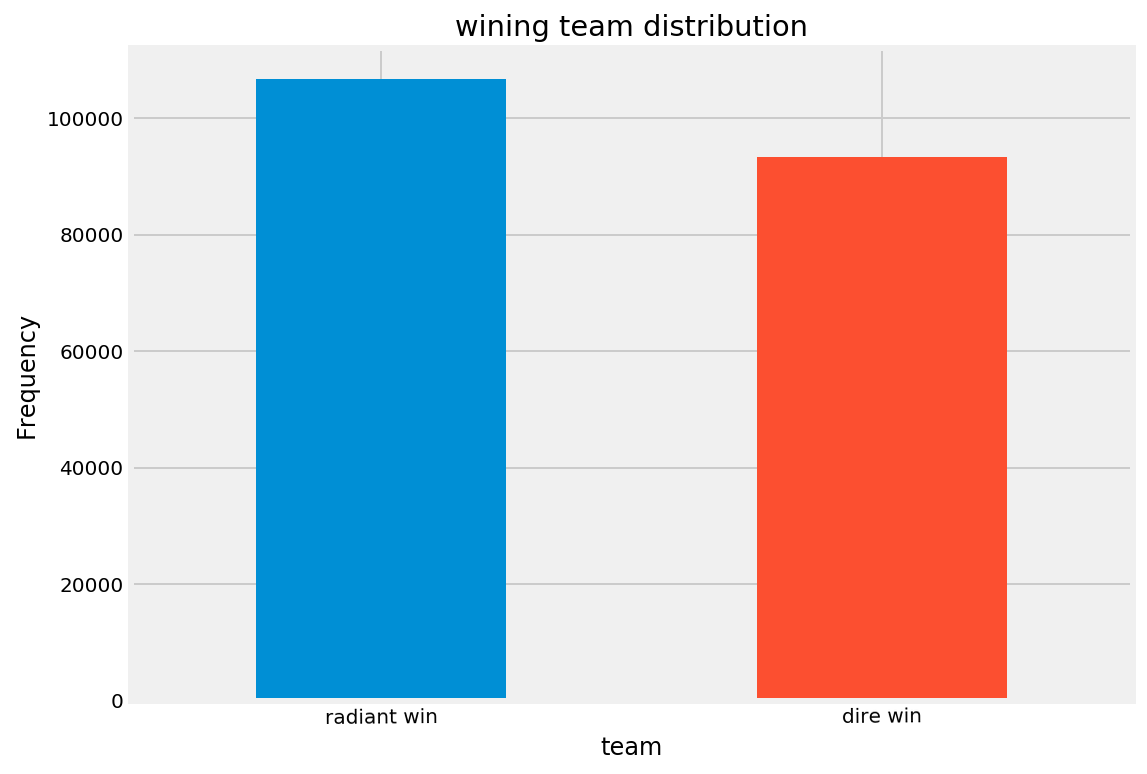

In [32]:
# plotting a target variable frequency using bar charts
df.radiant_win.value_counts().plot(kind='bar',rot=0.5,figsize=(8,6))
# labeling
plt.ylabel('Frequency')
plt.xlabel('team')
plt.title('wining team distribution')
#labeling tics
plt.xticks([0,1],['radiant win','dire win']);

##### there is embalanced issue with the target variable

##### plotting the distribution of both average rank and match duration

/Users/sultan.almuhanna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


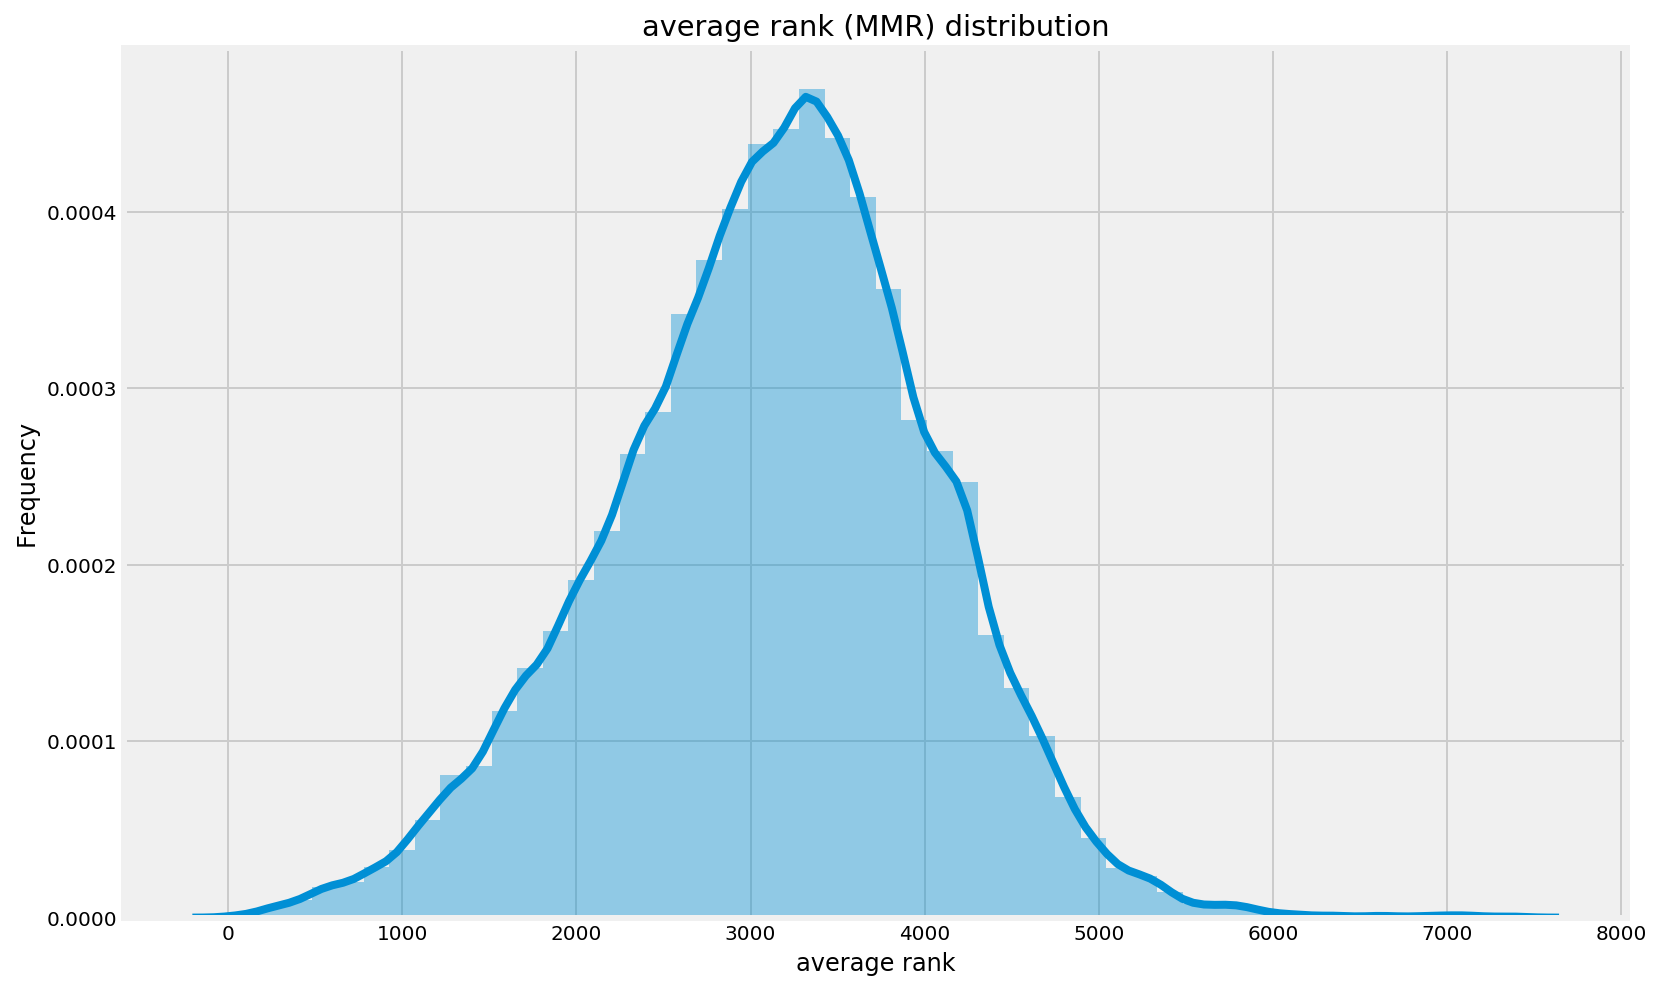

In [33]:
# checking the distribution of match player average rank
# setting the size of the figure
fig, ax = plt.subplots(figsize=(12,8))
# plotting
sns.distplot(df.avg_mmr,kde=True)
# labeling
plt.ylabel('Frequency')
plt.xlabel('average rank')
plt.title('average rank (MMR) distribution');

##### the rank scores of matches is almost normaly distributed, the highest portion of player ranks in matches are between 2000 and 4000 average rank.

/Users/sultan.almuhanna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


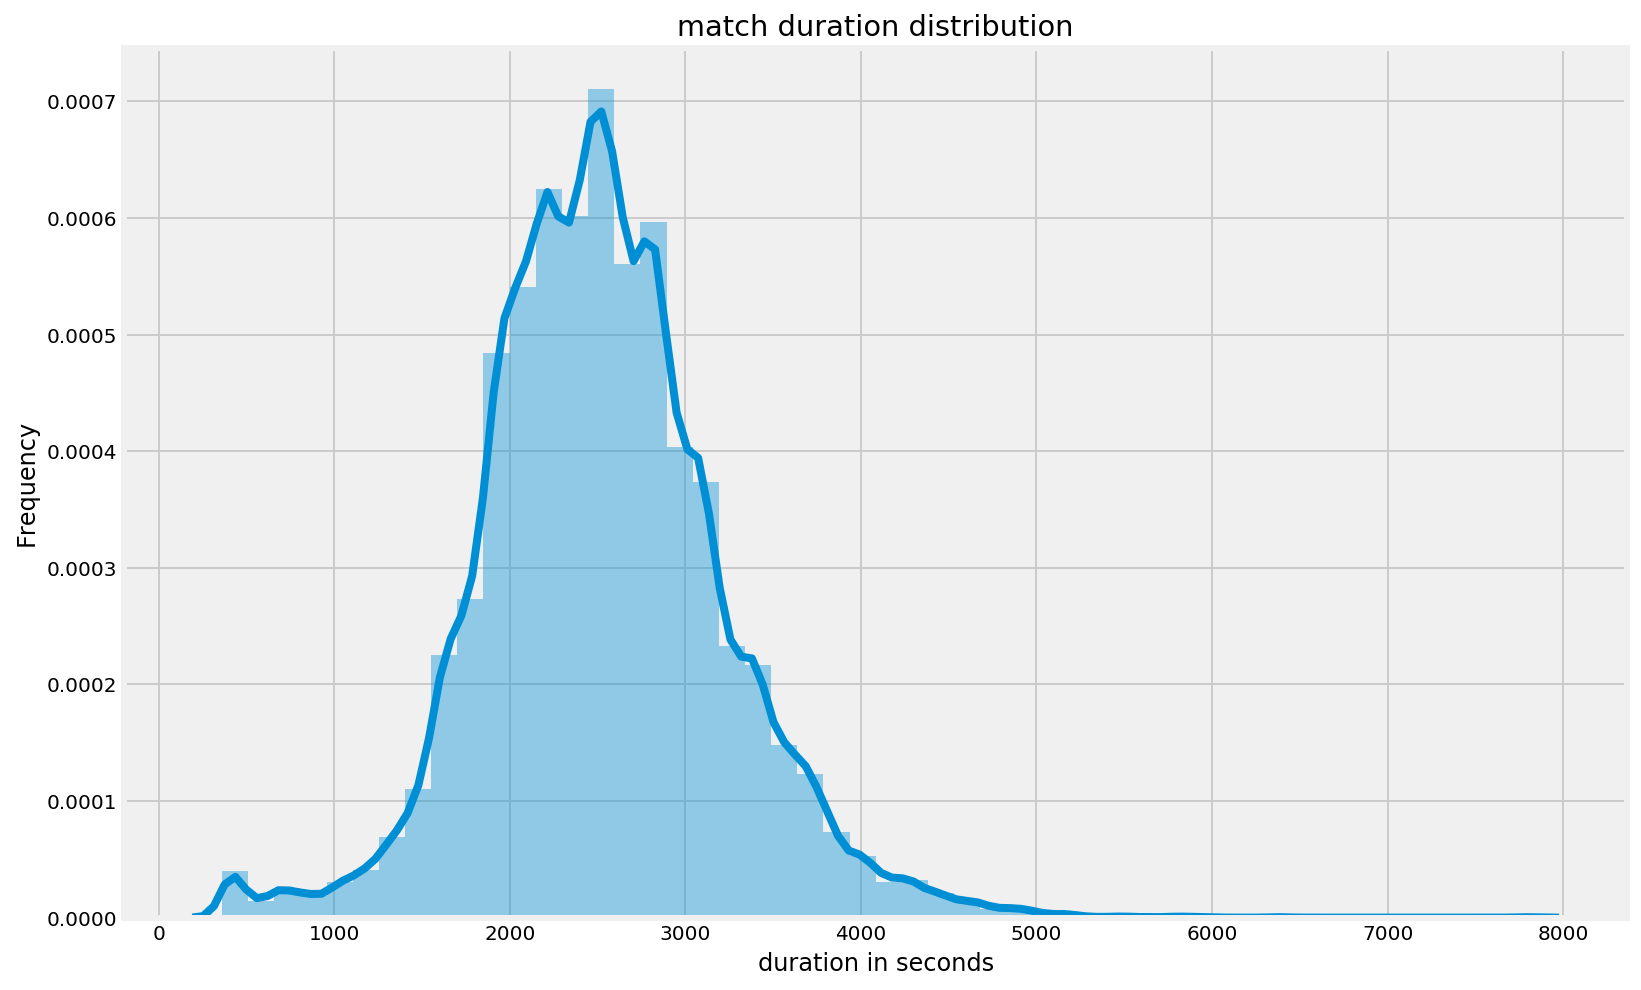

In [34]:
#checking the distribution of match duration
# setting the size of the figure
fig, ax = plt.subplots(figsize=(12,8))
# plotting
sns.distplot(df.duration,kde=True)
# labeling
plt.ylabel('Frequency')
plt.xlabel('duration in seconds')
plt.title('match duration distribution');

##### the duration column distribution is rightly postive skewed, majority of matches duration is between 2000 and 3000 seconds. also indicating that there is some outliers. 

In [35]:
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role
0,3300000109,0,False,1499498377,2362,4257,2,Ranked,All_Draft,98,Timbersaw,str,Melee,Nuker,Durable
1,3300000109,1,False,1499498377,2362,4257,2,Ranked,All_Draft,48,Luna,agi,Ranged,Carry,Nuker
2,3300000109,2,False,1499498377,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,int,Ranged,Support,Nuker
3,3300000109,3,False,1499498377,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,agi,Melee,Carry,Escape
4,3300000109,4,False,1499498377,2362,4257,2,Ranked,All_Draft,86,Rubick,int,Ranged,Support,Disabler


In [36]:
##### visualizing the four catagorical columns
def barChart_plotter(df):
    # the columns
    for i in ['lobby_type','game_mode','primary_attr','attack_type']:
        # plotting each
        df[i].value_counts().plot(kind='bar',figsize=(8,6),rot=0.5)
        # labeling
        plt.ylabel('frequency')
        plt.xlabel(i)
        plt.title('counts distribution')
        plt.show()

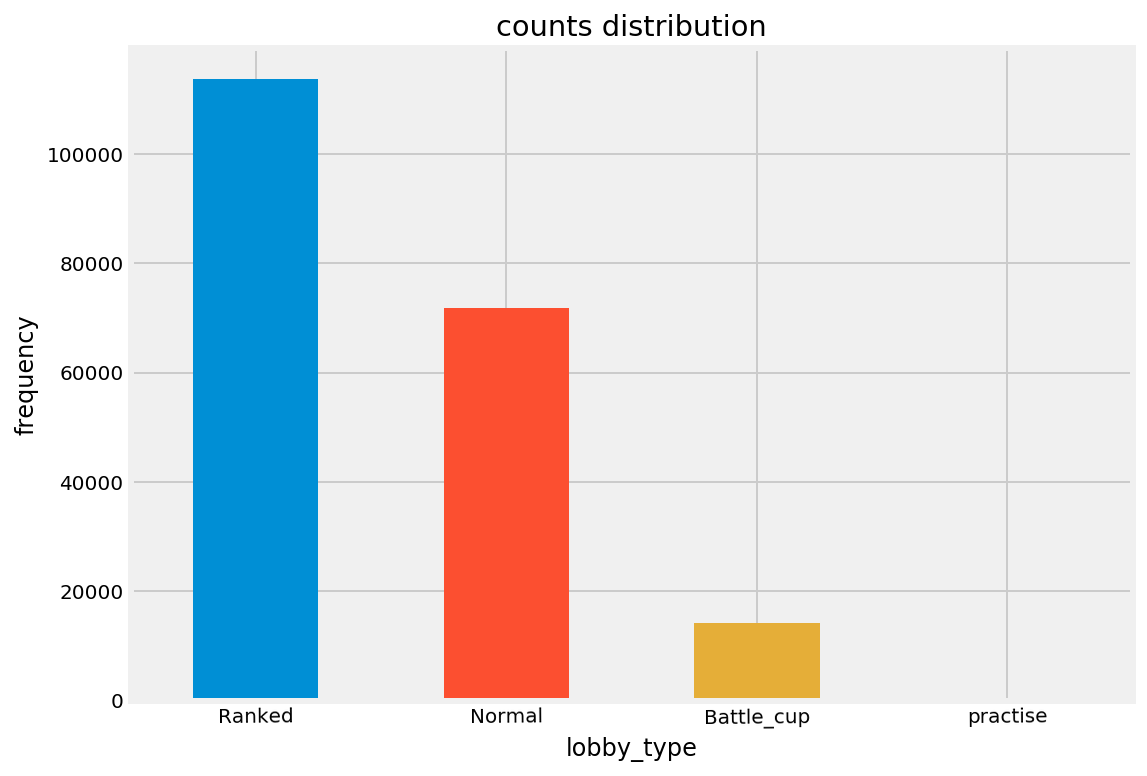

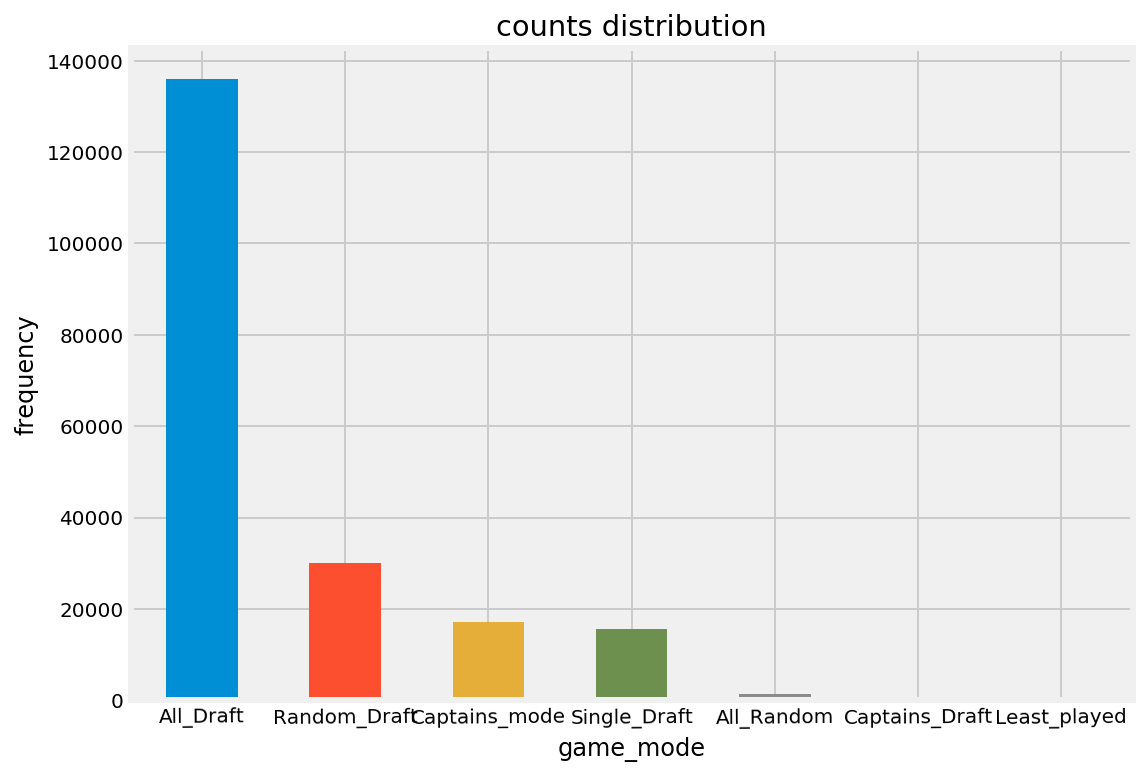

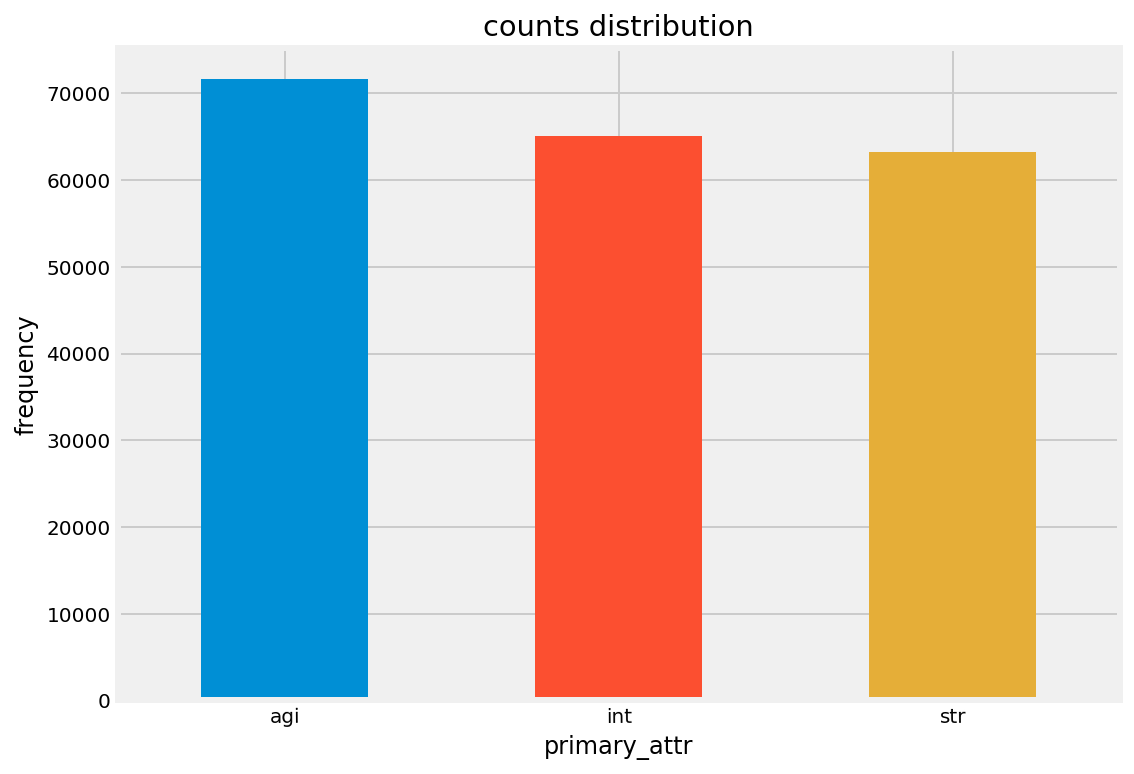

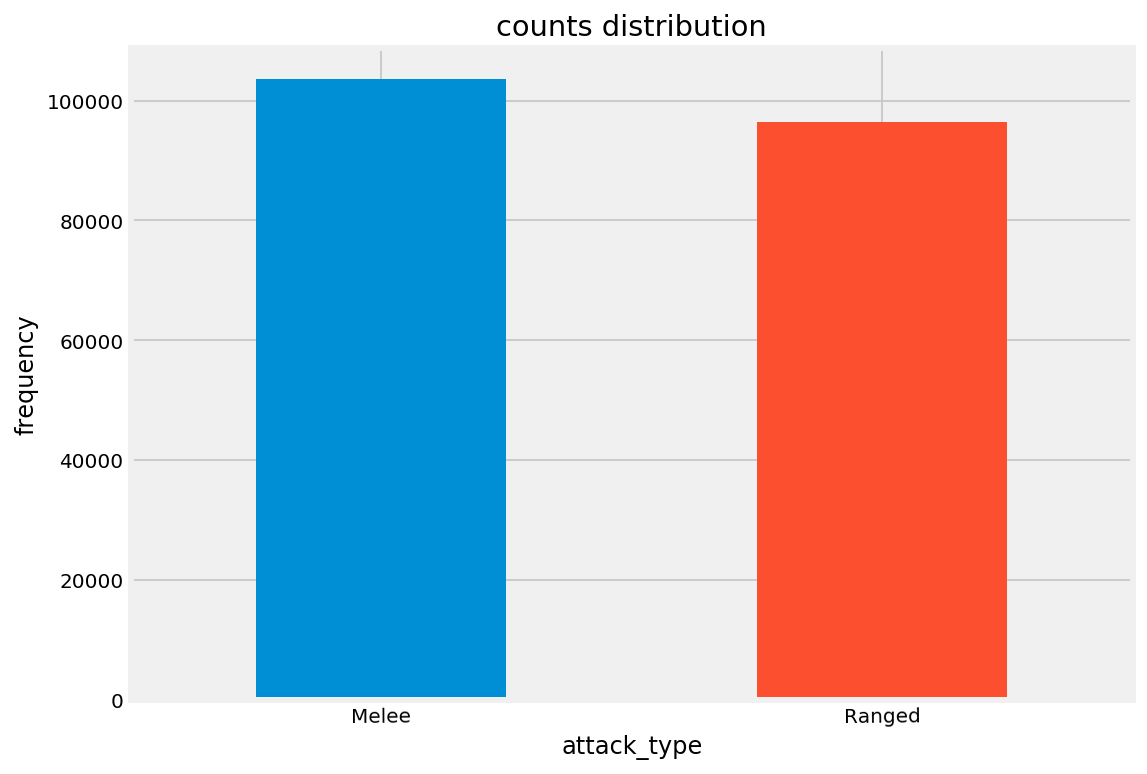

In [37]:
# calling the function on the dataframe
barChart_plotter(df)

##### columns attack_type and primary_attr are balanced wich is good becouse it will be used later for combinations.

###### Target corrolation 

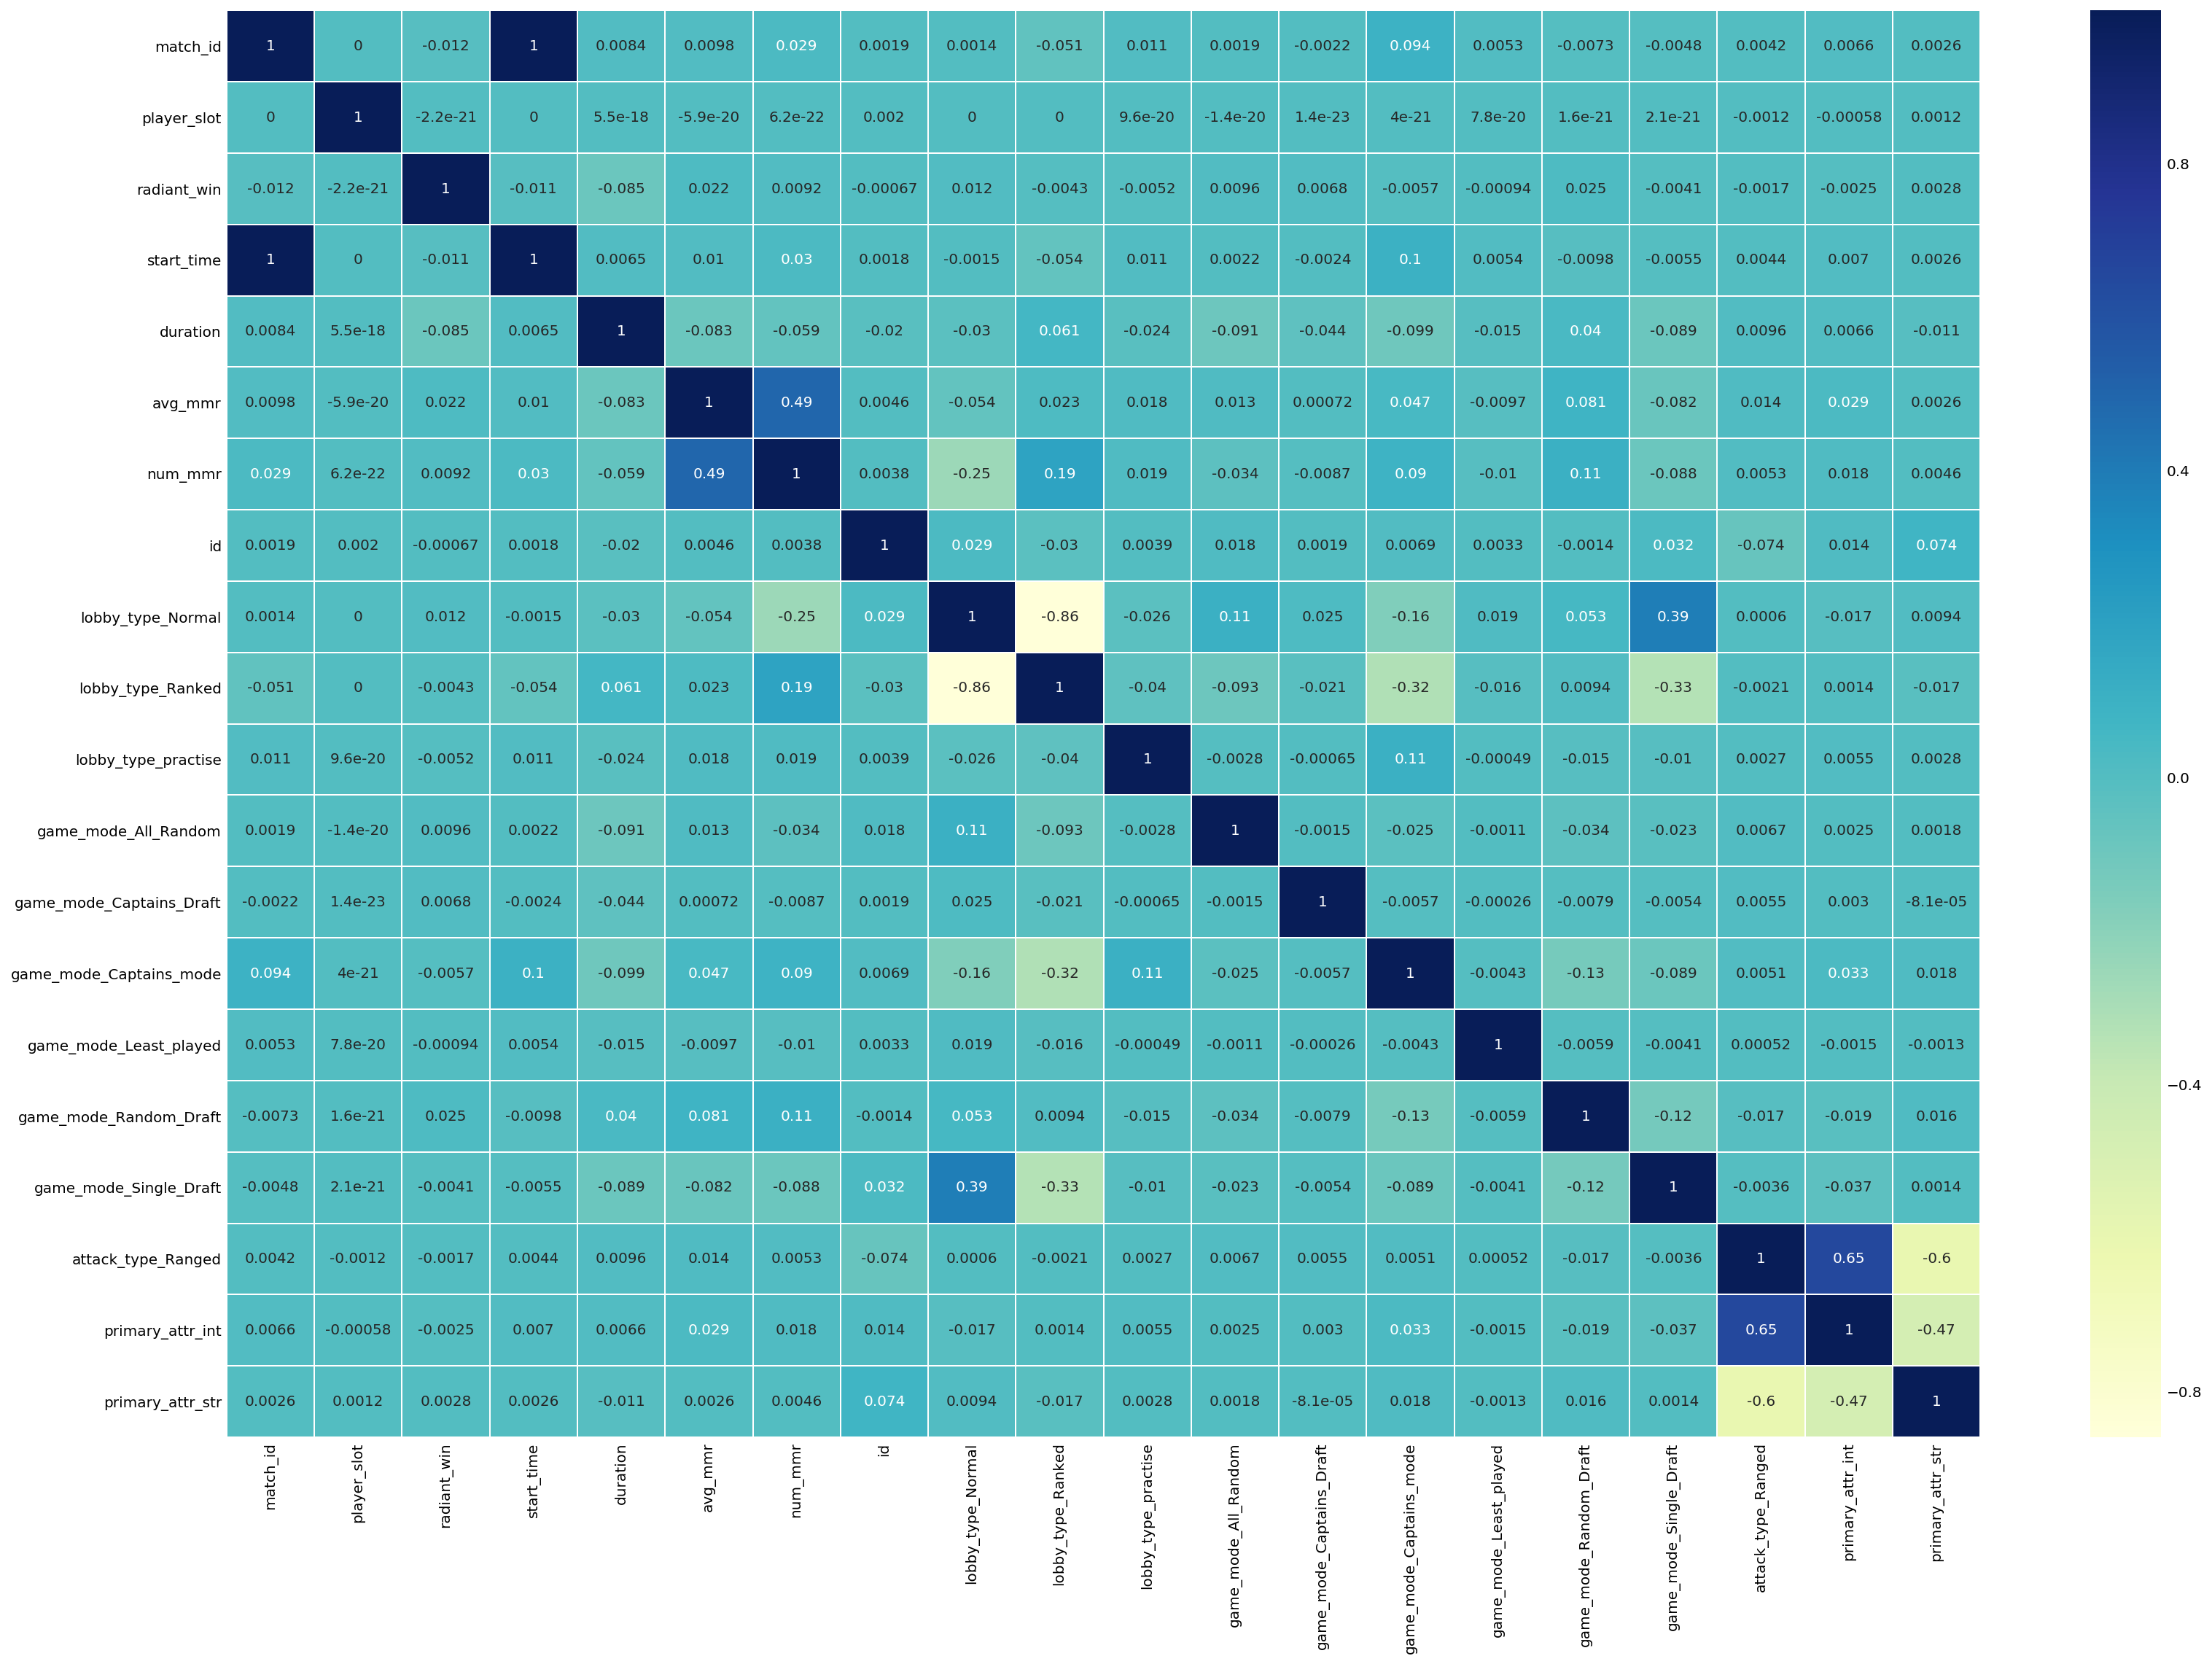

In [38]:
# printing a corrolation heatmap to loocate columns relationship with the target variable
# TODO: use RdBu and center 0 for better visualization

fig, ax = plt.subplots(figsize=(24,18)) 
sns.heatmap(cmap='YlGnBu',data=pd.get_dummies(df,columns=['lobby_type','game_mode','attack_type','primary_attr'],drop_first=True,).corr(), annot=True, linewidths=.5, ax=ax);

##### there is a very week corrolation between the target variable and other columns but after adding features, these featurs may have a better corrolation.

##### displaying the outliers

In [42]:
from sklearn.preprocessing import StandardScaler
# standerizing features for checking for outliers in the numaric values
scale = StandardScaler()
match_outliers = scale.fit_transform(df[['duration','avg_mmr','num_mmr']])
#transformig to a data frame
match_outliers= pd.DataFrame(match_outliers,columns=['duration','avg_mmr','num_mmr'])

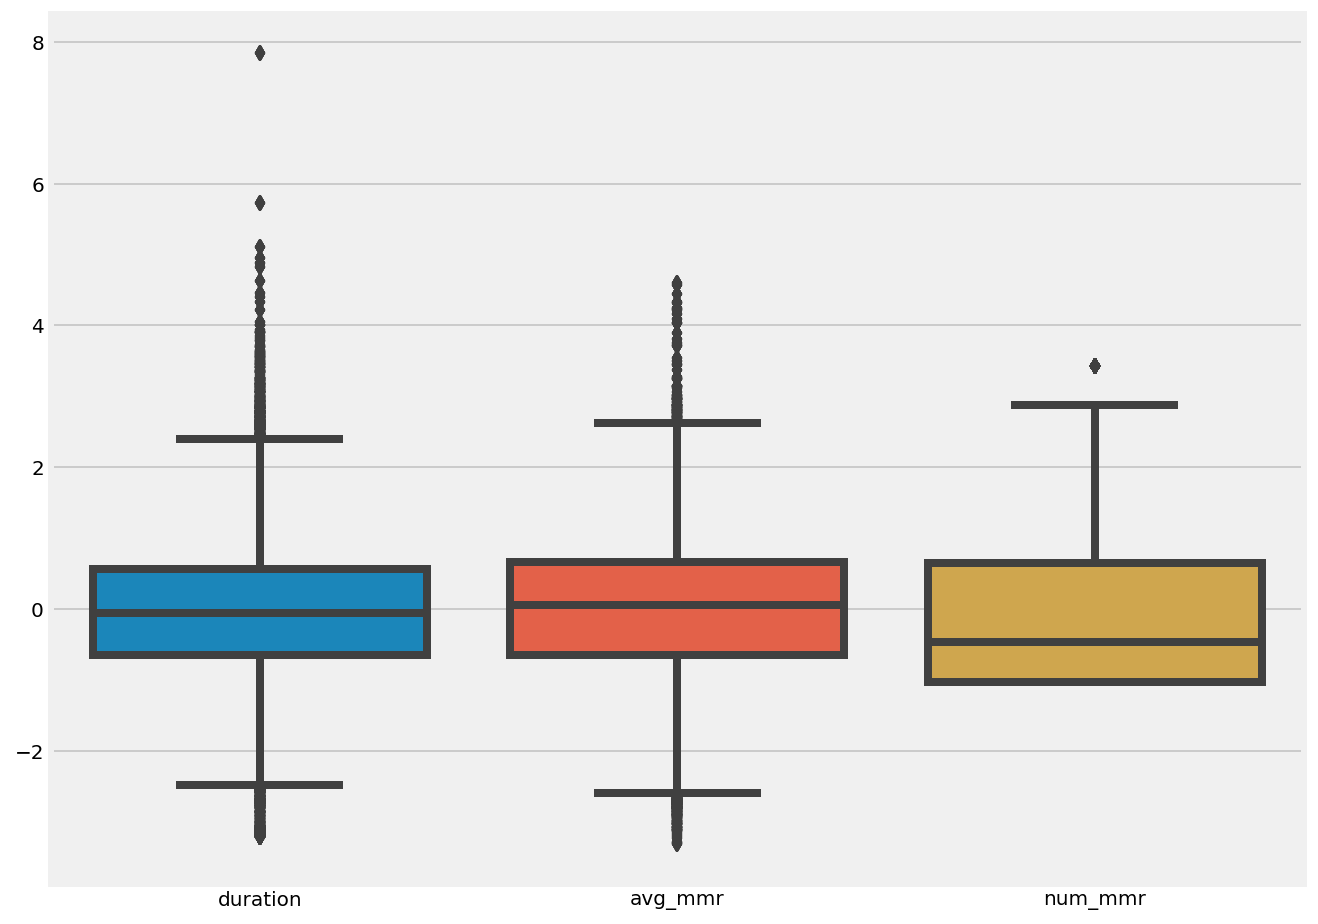

In [43]:
# displaying box plot
fig, ax = plt.subplots(figsize=(10,8)) 
sns.boxplot(data =match_outliers);

##### there is some outliers in the three columns, matches that took to long and rank averages that ware to high. the approuch is to remove them for better balancing

In [44]:
# removing the outliers that lay after +- 3 standerd deviation in the above attributes
# duration outlier
df = df[np.abs(df.duration-df.duration.mean()) <= (3*df.duration.std())]
# aerage rank outliers
df = df[np.abs(df.avg_mmr-df.avg_mmr.mean()) <= (3*df.avg_mmr.std())]
# num of ranked players outlier
df = df[np.abs(df.num_mmr-df.num_mmr.mean()) <= (3*df.num_mmr.std())]
df.shape

(196380, 15)

In [45]:
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role
0,3300000109,0,False,1499498377,2362,4257,2,Ranked,All_Draft,98,Timbersaw,str,Melee,Nuker,Durable
1,3300000109,1,False,1499498377,2362,4257,2,Ranked,All_Draft,48,Luna,agi,Ranged,Carry,Nuker
2,3300000109,2,False,1499498377,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,int,Ranged,Support,Nuker
3,3300000109,3,False,1499498377,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,agi,Melee,Carry,Escape
4,3300000109,4,False,1499498377,2362,4257,2,Ranked,All_Draft,86,Rubick,int,Ranged,Support,Disabler


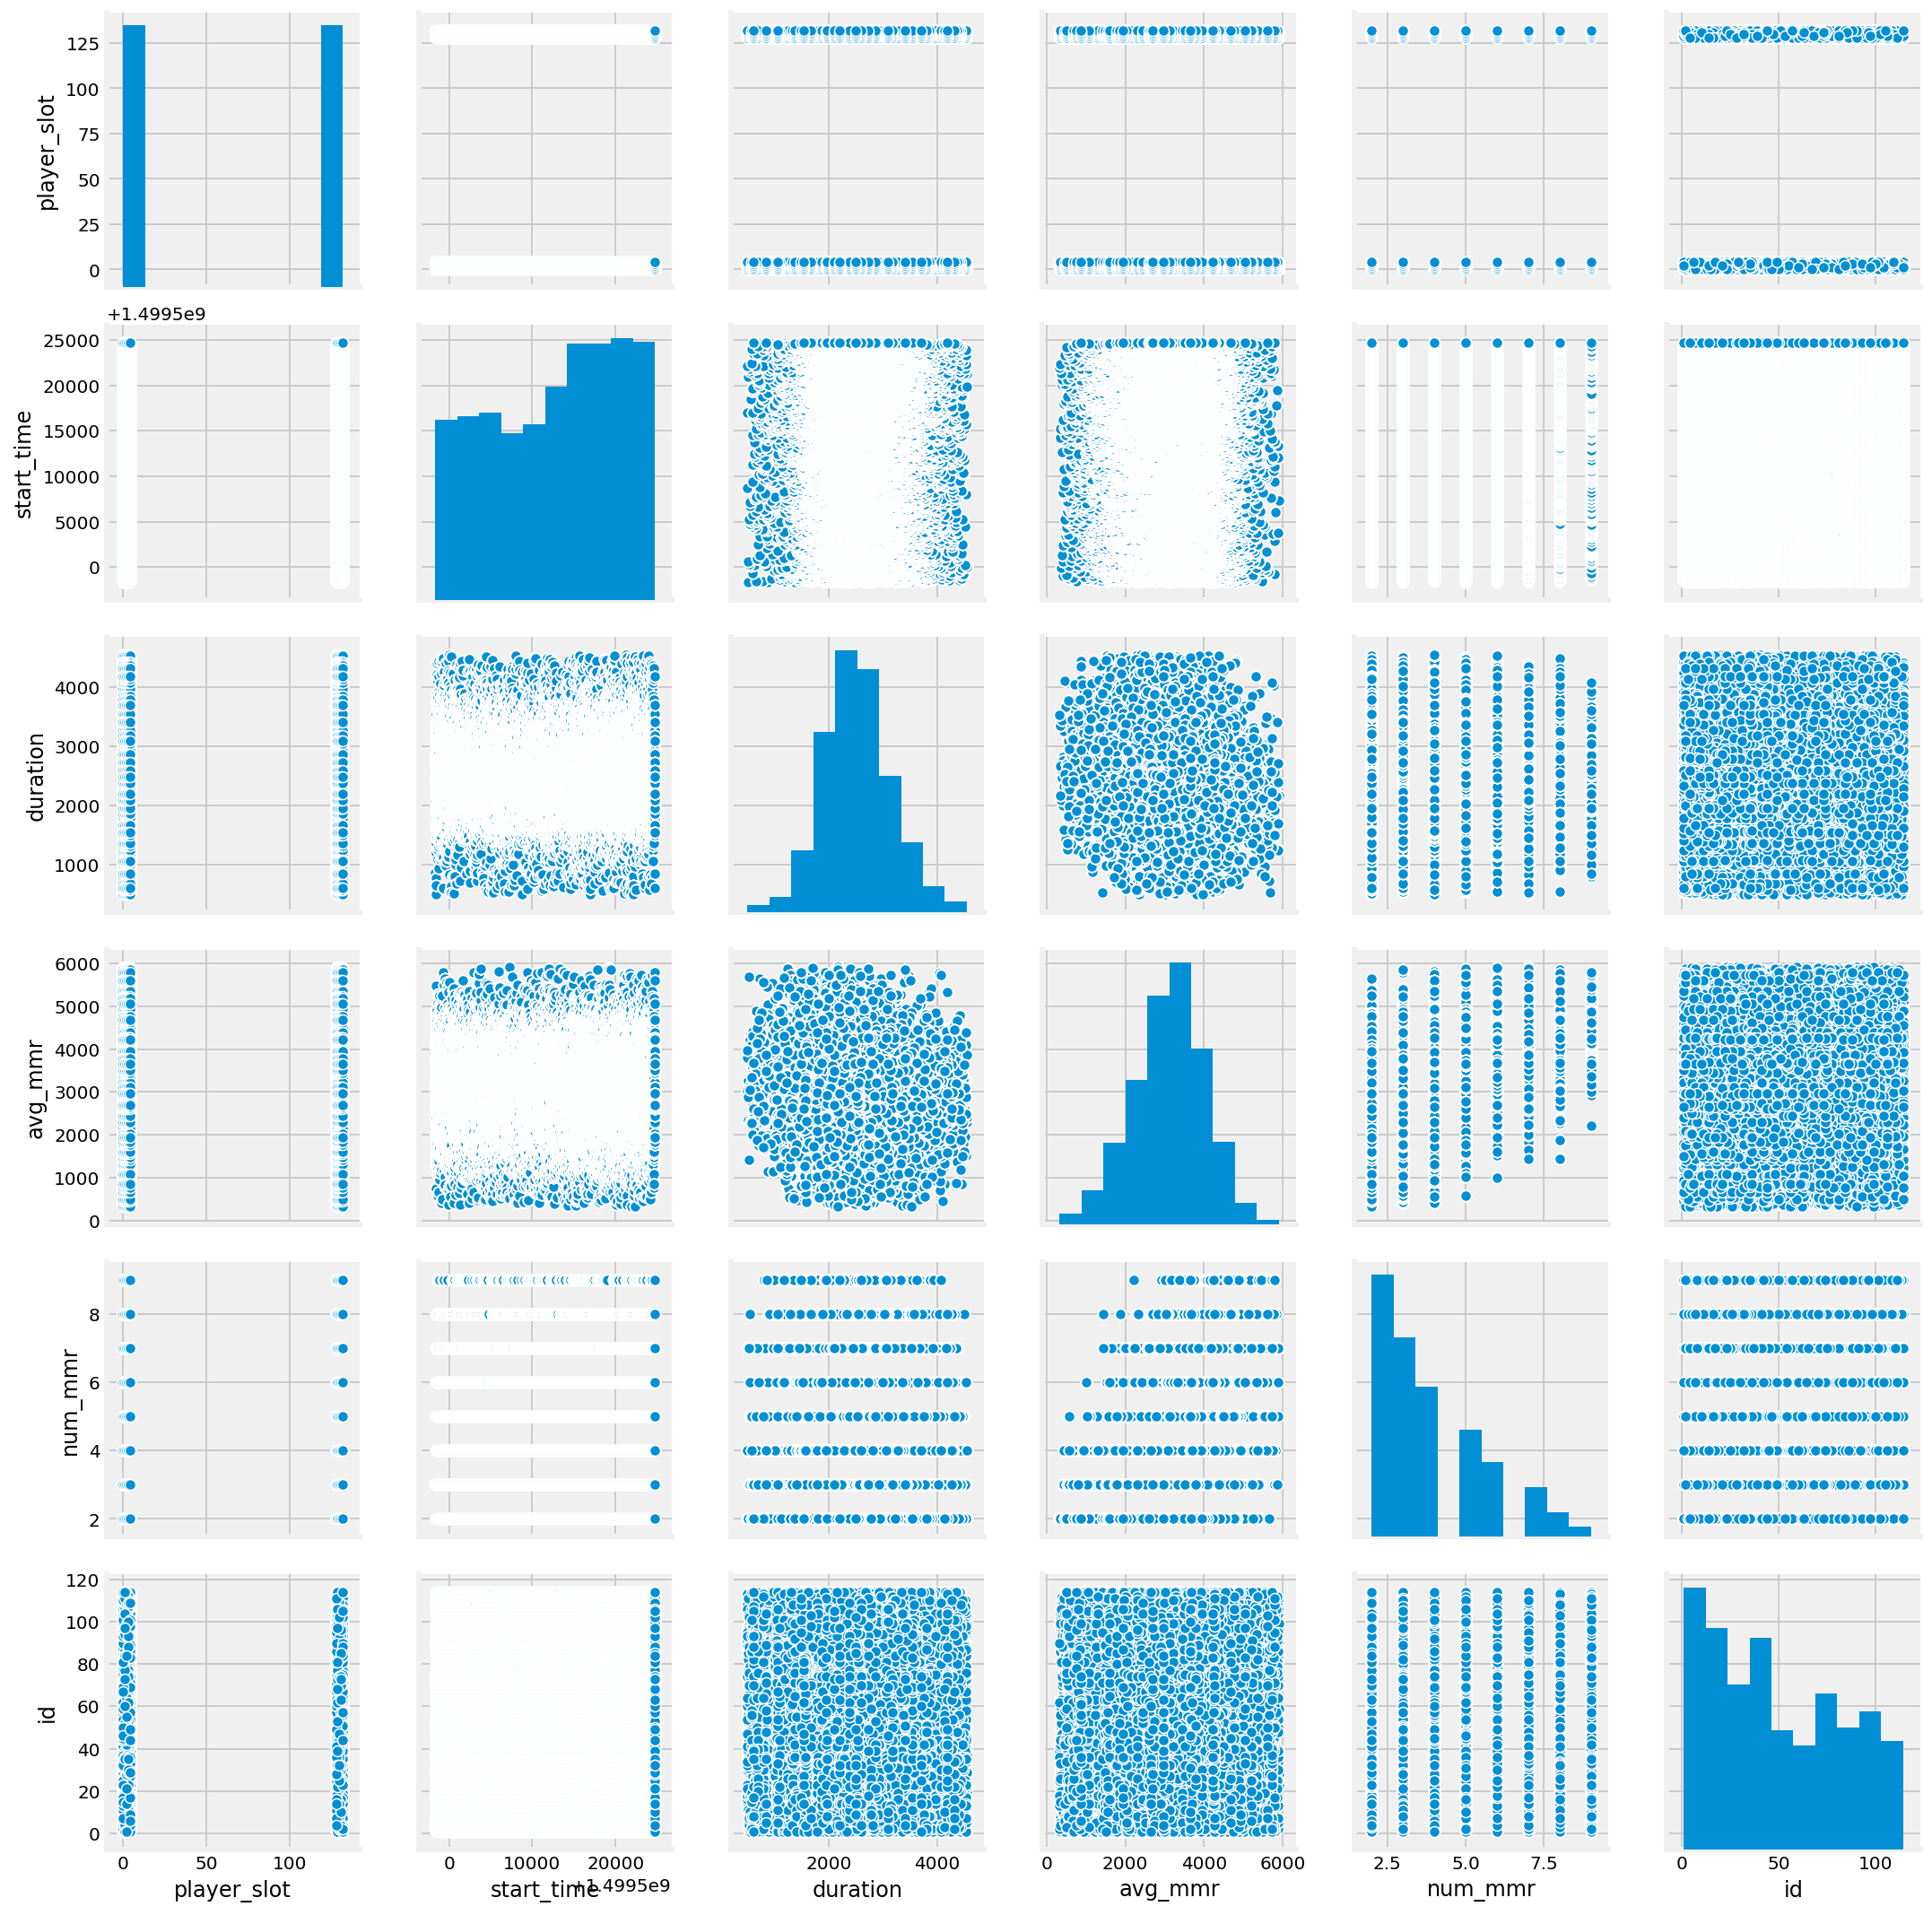

In [46]:
# viewing distribution between sale price and some highly corrolated attributes
sns.pairplot(df.drop(labels=['lobby_type','game_mode','radiant_win','name','primary_attr','attack_type','match_id','main_role','secondary_role'],axis=1))

##### exploring heros

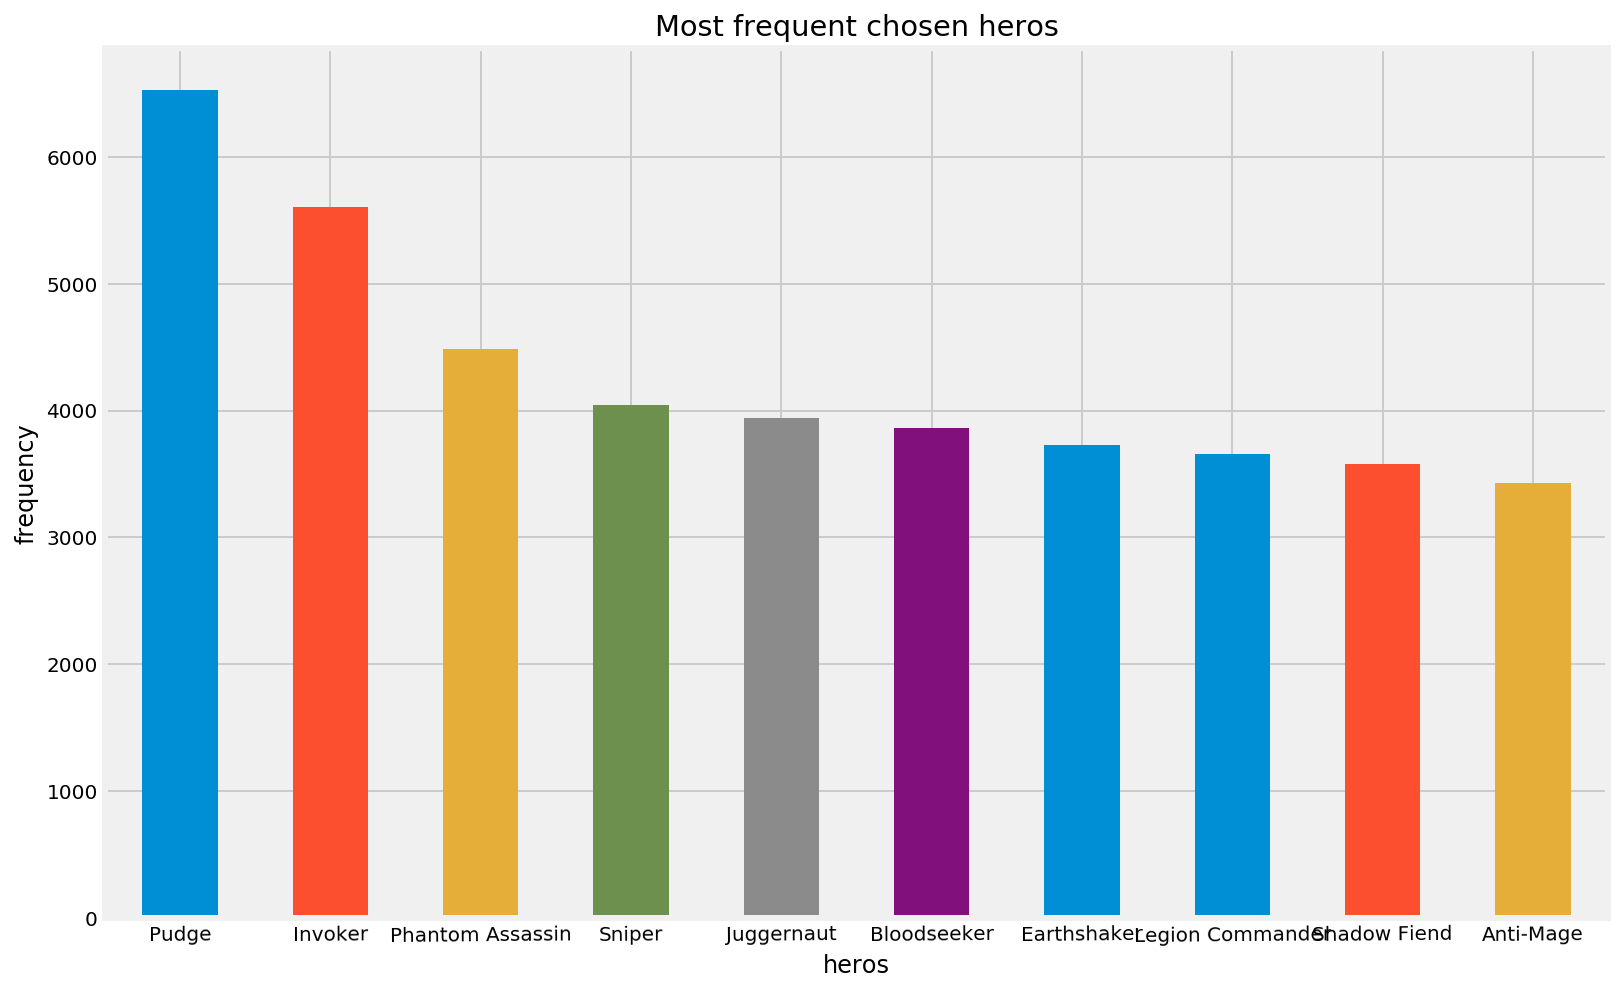

In [47]:
# displayng the 10 most frequent heros
df.name.value_counts().nlargest(10).plot(kind='bar',rot=0.5,figsize=(12,8));
plt.xlabel('heros')
plt.ylabel('frequency')
plt.title('Most frequent chosen heros');

In [48]:
# displaying the most frequent hero pick in winning teams

# first by splitting the radiant and dire 
mask_rad = df.loc[df.player_slot > 100]
mask_dire = df.loc[df.player_slot < 100]

# subsetting the winning matches
mask_rad = mask_rad.loc[mask_rad.radiant_win == True]
mask_dire = mask_dire.loc[mask_dire.radiant_win == False]

# concatting only the winning matches
winning_picks = pd.concat([mask_rad,mask_dire])
winning_picks.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role
15,3300000200,128,True,1499498377,2727,4147,5,Ranked,Random_Draft,2,Axe,str,Melee,Initiator,Durable
16,3300000200,129,True,1499498377,2727,4147,5,Ranked,Random_Draft,23,Kunkka,str,Melee,Carry,Support
17,3300000200,130,True,1499498377,2727,4147,5,Ranked,Random_Draft,76,Outworld Devourer,int,Ranged,Carry,Nuker
18,3300000200,131,True,1499498377,2727,4147,5,Ranked,Random_Draft,62,Bounty Hunter,agi,Melee,Escape,Nuker
19,3300000200,132,True,1499498377,2727,4147,5,Ranked,Random_Draft,18,Sven,str,Melee,Carry,Disabler


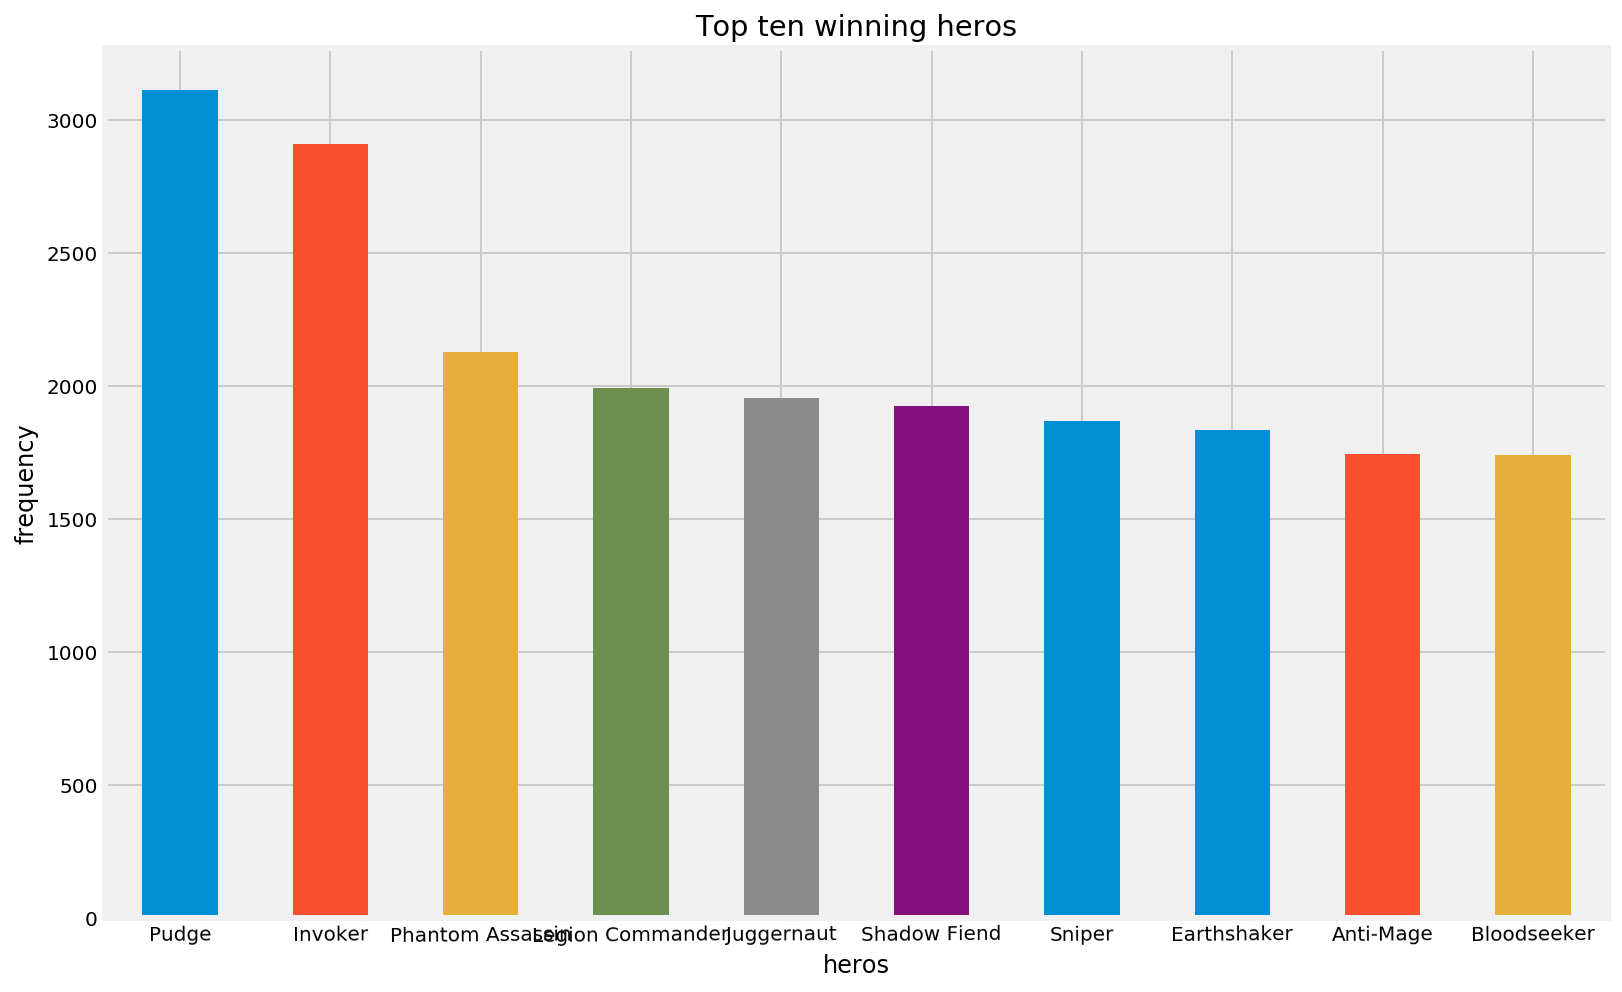

In [49]:
# displayng the 10 most frequent heros in winning matches
winning_picks.name.value_counts().nlargest(10).plot(kind='bar',rot=0.5,figsize=(12,8));
plt.xlabel('heros')
plt.ylabel('frequency')
plt.title('Top ten winning heros');

## Feature Engineering

##### becouse we only can determine if the observation is radiant or not is by the player_slot column that if its from 0 to 4 is radiant and from 128 to 132 is the radiant team. we need to creat a feature to determine if the row is radiant or not

In [50]:
# function to determine if the observation is radiant team or not
def adding_teams(df):
    teams = []
    # checking by the player slot
    for i in df.values:
        if i[1] > 100:
            teams.append(1)
        else:
            teams.append(0)
    df['radiant'] = teams
    # returning the resualts
    return df

In [51]:
# calling the function on the data frame
df = adding_teams(df)
df.head()

,match_id,player_slot,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role,radiant
0,3300000109,0,False,1499498377,2362,4257,2,Ranked,All_Draft,98,Timbersaw,str,Melee,Nuker,Durable,0
1,3300000109,1,False,1499498377,2362,4257,2,Ranked,All_Draft,48,Luna,agi,Ranged,Carry,Nuker,0
2,3300000109,2,False,1499498377,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,int,Ranged,Support,Nuker,0
3,3300000109,3,False,1499498377,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,agi,Melee,Carry,Escape,0
4,3300000109,4,False,1499498377,2362,4257,2,Ranked,All_Draft,86,Rubick,int,Ranged,Support,Disabler,0


##### converting the date from seconds to a date and time object and then extract the day of the week, month number, week number and hour of the day becouse it may have a large impact weather the player is playing at night or in the morning, and also at wich day they play week end or week days might also have an impact. Moreover, the number of month may also have an impact like if it is summer time or winte

In [52]:
# a function for converting the start time column from integer in seconds to  a date and timr object
def convert_date(df):
    date = []
    for i in df.values:
        
    # the format
        date_val = datetime.fromtimestamp(i[3]).strftime("%d/%m/%Y %I:%M:%S")
    # converting it to a date and time
        date.append(pd.to_datetime(date_val))
    # assigning the date list
    df['start_time'] = date
    # extracting the needed info
    df['day_of_week'] = df.start_time.dt.dayofweek
    df['month'] = df.start_time.dt.month
    df['week'] = df.start_time.dt.week
    df['hour'] = df.start_time.dt.hour
    df.drop(labels=['start_time'],axis=1,inplace=True)
    # returning the resualt
    return df


In [53]:
# using the function for conversion
df = convert_date(df)
df.head(5)

,match_id,player_slot,radiant_win,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role,radiant,day_of_week,month,week,hour
0,3300000109,0,False,2362,4257,2,Ranked,All_Draft,98,Timbersaw,str,Melee,Nuker,Durable,0,0,8,32,10
1,3300000109,1,False,2362,4257,2,Ranked,All_Draft,48,Luna,agi,Ranged,Carry,Nuker,0,0,8,32,10
2,3300000109,2,False,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,int,Ranged,Support,Nuker,0,0,8,32,10
3,3300000109,3,False,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,agi,Melee,Carry,Escape,0,0,8,32,10
4,3300000109,4,False,2362,4257,2,Ranked,All_Draft,86,Rubick,int,Ranged,Support,Disabler,0,0,8,32,10


## Preprocessing using three approuches

### Approuch 1:

##### approuch two is to take each match team, having two observations per match that describe each match info and taking the totals for heros types and attributes. data have fourty thousend observation.

In [54]:
# first by getting dummies for hero attributes and`types becouse we will take thier totals for each team
df_app1 = pd.get_dummies(df,columns=['primary_attr','attack_type'])
df_app1.head()

,match_id,player_slot,radiant_win,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,...,radiant,day_of_week,month,week,hour,primary_attr_agi,primary_attr_int,primary_attr_str,attack_type_Melee,attack_type_Ranged
0,3300000109,0,False,2362,4257,2,Ranked,All_Draft,98,Timbersaw,...,0,0,8,32,10,0,0,1,1,0
1,3300000109,1,False,2362,4257,2,Ranked,All_Draft,48,Luna,...,0,0,8,32,10,1,0,0,0,1
2,3300000109,2,False,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,...,0,0,8,32,10,0,1,0,0,1
3,3300000109,3,False,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,...,0,0,8,32,10,1,0,0,1,0
4,3300000109,4,False,2362,4257,2,Ranked,All_Draft,86,Rubick,...,0,0,8,32,10,0,1,0,0,1


In [122]:
# function to aggregate the values and reducing the observations by taking repeated values for each team
def first_app(df):
    # dictionary holding the needed features
    fin = {'avg_mmr':[],'num_mmr':[],'lobby_type':[],'game_mode':[],'tot_intel':[],
          'tot_stren':[],'tot_agi':[],'tot_range':[],'tot_melee':[],'radiant_win':[],'radiant':[],'day_of_week':[],
          'month':[],'week':[],'hour':[],'match_id':[]}
    # lists to add each team hero selection
    sub_rad = [[],[],[],[],[]]
    sub_dire = [[],[],[],[],[]]
    # cursers to hold the temprary values
    ind = 0
    tot_agi = 0
    tot_int = 0
    tot_str = 0
    melee = 0
    rang = 0
    # iterating over each row in the data set
    for i in df.values:
        # making the cursers to 0 when the team is first team is appended
        if ind == 5:
            ind = 0
            tot_agi = 0
            tot_int = 0
            tot_str = 0
            melee = 0
            rang = 0
        # checking for the team for value assignment 
        if i[1] >100:
            sub_rad[ind].append(i[9])
            ind +=1
            tot_agi += int(i[17])
            tot_int += int(i[18])
            tot_str += int(i[19])
            melee += int(i[20])
            rang += int(i[21])
        # second team assignmet    
        else:
            sub_dire[ind].append(i[9])
            ind +=1
            tot_agi += int(i[17])
            tot_int += int(i[18])
            tot_str += int(i[19])
            melee += int(i[20])
            rang += int(i[21])
        # assigninig the cursers and the repeated info in a dictionary  
        if ind == 5:
            fin['avg_mmr'].append(i[4]), fin['num_mmr'].append(i[5]), fin['lobby_type'].append(i[6])
            fin['game_mode'].append(i[7]), fin['tot_intel'].append(tot_int), fin['tot_stren'].append(tot_str)
            fin['tot_agi'].append(tot_agi), fin['tot_range'].append(rang), fin['tot_melee'].append(melee)
            fin['radiant_win'].append(i[2]), fin['radiant'].append(i[12]), fin['day_of_week'].append(i[13])
            fin['month'].append(i[14]), fin['week'].append(i[15]), fin['hour'].append(i[16])
            fin['match_id'].append(i[0])
    # joining the heros and aggregated data for each team and then combine them
    # Dire team
    fin = pd.DataFrame(fin)
    fin_d = fin.loc[fin.radiant == 0]
    fin_d.reset_index(drop=True,inplace=True)
    sub_dire = pd.DataFrame(sub_dire)
    sub_dire = sub_dire.T
    sub_dire.columns = ['player_1','player_2','player_3',
          'player_4','player_5']
    fin_d = fin_d.join(sub_dire)
    # radiant team
    fin_r = fin.loc[fin.radiant == 1]
    fin_r.reset_index(drop=True,inplace=True)
    sub_rad = pd.DataFrame(sub_rad)
    sub_rad = sub_rad.T
    sub_rad.columns = ['player_1','player_2','player_3',
          'player_4','player_5']
    fin_r = fin_r.join(sub_rad)
    fin = pd.concat([fin_r,fin_d])
    # returning the resualts
    return fin

In [56]:
# calling the aggrigator function in the seconed approuch
df_app1 = first_app(df_app1)
df_app1.head()

,avg_mmr,num_mmr,lobby_type,game_mode,tot_intel,tot_stren,tot_agi,tot_range,tot_melee,radiant_win,...,day_of_week,month,week,hour,match_id,player_1,player_2,player_3,player_4,player_5
0,4257,2,Ranked,All_Draft,1,3,1,1,4,False,...,0,8,32,10,3300000109,Juggernaut,Lifestealer,Spirit Breaker,Slardar,Lina
1,4147,5,Ranked,Random_Draft,1,3,1,1,4,True,...,0,8,32,10,3300000200,Axe,Kunkka,Outworld Devourer,Bounty Hunter,Sven
2,4811,6,Ranked,All_Draft,2,1,2,3,2,True,...,0,8,32,10,3300000206,Shadow Fiend,Axe,Faceless Void,Crystal Maiden,Keeper of the Light
3,3148,3,Ranked,All_Draft,3,1,1,3,2,True,...,0,8,32,10,3300000404,Lina,Undying,Bloodseeker,Necrophos,Tinker
4,4261,5,Ranked,All_Draft,1,2,2,2,3,False,...,0,8,32,10,3300000405,Ursa,Clockwerk,Shadow Fiend,Pudge,Skywrath Mage


##### the next step is to transform the heros names to binary without the position of the hero, meaning making each team observation have all heros. adding 1 to each hero in the team, ending up with 5 ones in each row detemining team picks rather than dummifieing it becouse it will be sensitive to player posisioning.

In [59]:
# first by making an empty datadrame including all the unieque heros in the game
app1_heros = pd.DataFrame(columns=df_app1.player_1.unique())
app1_heros = app1_heros.to_dict(orient='list')
# list of all heros
hers = df_app1.player_1.unique()
hers


array(['Juggernaut', 'Axe', 'Shadow Fiend', 'Lina', 'Ursa', 'Mirana',
       'Sniper', 'Kunkka', 'Vengeful Spirit', 'Lifestealer',
       'Bristleback', 'Queen of Pain', 'Riki', 'Puck', 'Slark', 'Jakiro',
       'Razor', 'Sven', 'Windranger', 'Monkey King', 'Troll Warlord',
       'Skywrath Mage', 'Earthshaker', 'Clinkz', 'Storm Spirit',
       'Batrider', 'Tusk', 'Spectre', 'Luna', 'Meepo', 'Crystal Maiden',
       'Bounty Hunter', 'Wraith King', 'Nyx Assassin', 'Winter Wyvern',
       'Terrorblade', 'Abaddon', 'Broodmother', 'Huskar', 'Rubick',
       'Anti-Mage', 'Keeper of the Light', 'Templar Assassin', 'Invoker',
       'Tinker', 'Warlock', 'Silencer', 'Phantom Assassin',
       'Death Prophet', 'Pudge', 'Ember Spirit', 'Morphling', 'Enigma',
       'Slardar', 'Bloodseeker', 'Legion Commander', 'Weaver',
       'Spirit Breaker', 'Disruptor', 'Sand King', 'Undying', 'Alchemist',
       'Ogre Magi', 'Drow Ranger', 'Dazzle', 'Clockwerk', 'Tiny', 'Lion',
       'Faceless Void', 'Vipe

In [63]:
# function to add heros to the empty hero DataFrame
def hero_generator(df):
    # looping over all the observations
    for i in df.values:
        # looping over the list of heros
            for ind in hers:
                # checking if the givin value rows for heros equals the current hero list item and appending each
                # to its corrosponding pick
                if (i[16] == ind) or (i[17] == ind) or (i[18] == ind) or (i[19] == ind) or (i[20] == ind):
                    app1_heros[ind].append(1)
                
                else:
                    app1_heros[ind].append(0)
    return app1_heros
  

In [64]:
# calling the function
app1_heros = pd.DataFrame(hero_generator(df_app1))
app1_heros.head()

,Juggernaut,Axe,Shadow Fiend,Lina,Ursa,Mirana,Sniper,Kunkka,Vengeful Spirit,Lifestealer,...,Chen,Enchantress,Io,Brewmaster,Phantom Lancer,Treant Protector,Shadow Demon,Oracle,Beastmaster,Naga Siren
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# dropping after taking the heros from the in the previos function
df_app1.drop(labels=['player_1','player_2','player_3','player_4','player_5'],axis=1,inplace=True)

In [66]:
# joining the heros Dataframe with the team aggregated DataFrame
df_app1 = df_app1.join(app1_heros)
df_app1.reset_index(drop=True,inplace=True)

df_app1.head(5)

,avg_mmr,num_mmr,lobby_type,game_mode,tot_intel,tot_stren,tot_agi,tot_range,tot_melee,radiant_win,...,Chen,Enchantress,Io,Brewmaster,Phantom Lancer,Treant Protector,Shadow Demon,Oracle,Beastmaster,Naga Siren
0,4257,2,Ranked,All_Draft,1,3,1,1,4,False,...,0,0,0,0,0,0,0,0,0,0
1,4257,2,Ranked,All_Draft,2,1,2,3,2,False,...,0,0,0,0,0,0,0,0,0,0
2,4147,5,Ranked,Random_Draft,1,3,1,1,4,True,...,0,0,0,0,0,0,0,0,0,0
3,4147,5,Ranked,Random_Draft,1,2,2,1,4,True,...,0,0,0,0,0,0,0,0,0,0
4,4811,6,Ranked,All_Draft,2,1,2,3,2,True,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# getting dummies for radiant win
df_app1 = pd.get_dummies(df_app1,columns=['radiant_win'],drop_first=True)
# getting dummies to the rest of the categorical variables
#df_app1 = df_app1.drop(labels=['avg_mmr','lobby_type','game_mode','num_mmr','day_of_week','month','week','hour',
                           #   'tot_intel','tot_stren','tot_agi','tot_range','tot_melee','radiant'],axis=1)
df_app1 = pd.get_dummies(df_app1)
'''note not getting them together is becouse later will be extracting the features for statistical reason
the needs all features to display'''
#df_app1 = df_app1.loc[df_app1.radiant == 1]
df_app1.head()

,avg_mmr,num_mmr,tot_intel,tot_stren,tot_agi,tot_range,tot_melee,radiant,day_of_week,month,...,lobby_type_Normal,lobby_type_Ranked,lobby_type_practise,game_mode_All_Draft,game_mode_All_Random,game_mode_Captains_Draft,game_mode_Captains_mode,game_mode_Least_played,game_mode_Random_Draft,game_mode_Single_Draft
0,4257,2,1,3,1,1,4,1,0,8,...,0,1,0,1,0,0,0,0,0,0
1,4257,2,2,1,2,3,2,0,0,8,...,0,1,0,1,0,0,0,0,0,0
2,4147,5,1,3,1,1,4,1,0,8,...,0,1,0,0,0,0,0,0,1,0
3,4147,5,1,2,2,1,4,0,0,8,...,0,1,0,0,0,0,0,0,1,0
4,4811,6,2,1,2,3,2,1,0,8,...,0,1,0,1,0,0,0,0,0,0


In [68]:
df_app1.to_csv('app1',index=False)

### Approuch 2:

##### sconed approuch is to aggregate each match in one observation that include the diffrences in hero type and attributes between teams along with holding each teams pick

In [97]:
# first by getting dummies for hero attributes and types becouse we will take thier totals for each team
df_app2 = pd.get_dummies(df,columns=['primary_attr','attack_type'])
df_app2.head()

,match_id,player_slot,radiant_win,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,...,radiant,day_of_week,month,week,hour,primary_attr_agi,primary_attr_int,primary_attr_str,attack_type_Melee,attack_type_Ranged
0,3300000109,0,False,2362,4257,2,Ranked,All_Draft,98,Timbersaw,...,0,0,8,32,10,0,0,1,1,0
1,3300000109,1,False,2362,4257,2,Ranked,All_Draft,48,Luna,...,0,0,8,32,10,1,0,0,0,1
2,3300000109,2,False,2362,4257,2,Ranked,All_Draft,90,Keeper of the Light,...,0,0,8,32,10,0,1,0,0,1
3,3300000109,3,False,2362,4257,2,Ranked,All_Draft,106,Ember Spirit,...,0,0,8,32,10,1,0,0,1,0
4,3300000109,4,False,2362,4257,2,Ranked,All_Draft,86,Rubick,...,0,0,8,32,10,0,1,0,0,1


In [98]:
# first by creating a function to combine all heros in both teams of the same match
def combination(df):
    her = {'dire_plyr_1':[],'dire_plyr_2':[],'dire_plyr_3':[],'dire_plyr_4':[],'dire_plyr_5':[],
           'rad_plyr_1':[],'rad_plyr_2':[],'rad_plyr_3':[],'rad_plyr_4':[],'rad_plyr_5':[]}
    # appending variables based on the player slot to indicate the hero team
    for row in df.values:
        if row[1]  == 0:
            her['dire_plyr_1'].append(row[9])
        elif row[1]  == 1:
            her['dire_plyr_2'].append(row[9])
        elif row[1]  == 2:
            her['dire_plyr_3'].append(row[9])
        elif row[1] == 3:
            her['dire_plyr_4'].append(row[9])
        elif row[1] == 4:
            her['dire_plyr_5'].append(row[9])
        elif row[1]  == 128:
            her['rad_plyr_1'].append(row[9])
        elif row[1]  == 129:
            her['rad_plyr_2'].append(row[9])
        elif row[1]  == 130:
            her['rad_plyr_3'].append(row[9])
        elif row[1] == 131:
            her['rad_plyr_4'].append(row[9])
        elif row[1] == 132:
            her['rad_plyr_5'].append(row[9])
    # returning the resualts
    return pd.DataFrame(her)

In [99]:
# calling the function and saving it for later join with the main dataFrame
app2_heros = combination(df_app2)
app2_heros.head()

,dire_plyr_1,dire_plyr_2,dire_plyr_3,dire_plyr_4,dire_plyr_5,rad_plyr_1,rad_plyr_2,rad_plyr_3,rad_plyr_4,rad_plyr_5
0,Timbersaw,Luna,Keeper of the Light,Ember Spirit,Rubick,Juggernaut,Lifestealer,Spirit Breaker,Slardar,Lina
1,Pudge,Bloodseeker,Sand King,Disruptor,Ember Spirit,Axe,Kunkka,Outworld Devourer,Bounty Hunter,Sven
2,Legion Commander,Jakiro,Storm Spirit,Nature's Prophet,Juggernaut,Shadow Fiend,Axe,Faceless Void,Crystal Maiden,Keeper of the Light
3,Pudge,Mirana,Spectre,Kunkka,Weaver,Lina,Undying,Bloodseeker,Necrophos,Tinker
4,Spectre,Earthshaker,Huskar,Centaur Warrunner,Invoker,Ursa,Clockwerk,Shadow Fiend,Pudge,Skywrath Mage


In [100]:
# function to return a Dataframe that have the diffrences and the other needded info
def match_all_teams(df):   
    # dictionary of the needed info of diffrences and other requared data
    diff = {'avg_mmr':[],'diff_intel':[],'diff_stren':[],'diff_agi':[],'diff_range':[],'diff_melee':[],
            'radiant_win':[],'match_id':[]}
    # creating temporary cursers
    df = second_app(df)
    counter = 0
    intel = 0
    agil = 0
    stren = 0
    melee = 0
    rang = 0
    df = df.sort_values(by=['match_id'])
    # looping over all values
    for row in df.values:
        if counter == 2:
            counter = 0
            intel = 0
            agil = 0
            stren = 0
            melee = 0
            rang = 0
        # checking for the counter to distingushe between teams
        if counter == 0:
            intel = row[4]
            agil = row[6]
            stren = row[5]
            rang = row[7]
            melee = row[8]
        if counter == 1:
            intel =intel - row[4]
            agil = agil - row[6]
            stren =stren - row[5]
            rang =rang - row[7]
            melee = rang - row[8]
        counter +=1
        # checking from the counter weather the diffrence ware taken or not
        if counter == 2:
            # appending the values 
            diff['avg_mmr'].append(row[0]), diff['diff_intel'].append(intel), diff['diff_stren'].append(stren)
            diff['diff_agi'].append(agil), diff['diff_range'].append(rang),  diff['diff_melee'].append(melee)
            diff['radiant_win'].append(row[9]), diff['match_id'].append(row[15])
    # converting the resualts to a Dataframe and returning it
    diff = pd.DataFrame(diff)
    return diff
 

In [101]:
# calling the previose function
df_app2 = match_all_teams(df_app2)
df_app2.head()

,avg_mmr,diff_intel,diff_stren,diff_agi,diff_range,diff_melee,radiant_win,match_id
0,4257,-1,2,-1,-2,-4,False,3300000109
1,4147,0,-1,1,0,-4,True,3300000200
2,4811,-1,0,1,0,-2,True,3300000206
3,3148,3,-1,-2,1,-2,True,3300000404
4,4261,0,-1,1,0,-3,False,3300000405


In [102]:
# joining the heros and the one onservation dataset per match
df_app2 = df_app2.join(app2_heros)
df_app2.head()

,avg_mmr,diff_intel,diff_stren,diff_agi,diff_range,diff_melee,radiant_win,match_id,dire_plyr_1,dire_plyr_2,dire_plyr_3,dire_plyr_4,dire_plyr_5,rad_plyr_1,rad_plyr_2,rad_plyr_3,rad_plyr_4,rad_plyr_5
0,4257,-1,2,-1,-2,-4,False,3300000109,Timbersaw,Luna,Keeper of the Light,Ember Spirit,Rubick,Juggernaut,Lifestealer,Spirit Breaker,Slardar,Lina
1,4147,0,-1,1,0,-4,True,3300000200,Pudge,Bloodseeker,Sand King,Disruptor,Ember Spirit,Axe,Kunkka,Outworld Devourer,Bounty Hunter,Sven
2,4811,-1,0,1,0,-2,True,3300000206,Legion Commander,Jakiro,Storm Spirit,Nature's Prophet,Juggernaut,Shadow Fiend,Axe,Faceless Void,Crystal Maiden,Keeper of the Light
3,3148,3,-1,-2,1,-2,True,3300000404,Pudge,Mirana,Spectre,Kunkka,Weaver,Lina,Undying,Bloodseeker,Necrophos,Tinker
4,4261,0,-1,1,0,-3,False,3300000405,Spectre,Earthshaker,Huskar,Centaur Warrunner,Invoker,Ursa,Clockwerk,Shadow Fiend,Pudge,Skywrath Mage


In [103]:
# getting dummies for radiant win
# dropping the duration column becouse its collected after the match has ended, and the problem statment indicated
# that the prediction will be after hero selection in the start of the match
df_app2 = pd.get_dummies(df_app2,columns=['radiant_win'],drop_first=True)
# getting dummies to the rest of the categorical variables
df_app2 = pd.get_dummies(df_app2)
'''note not getting the dumification them together is becouse later will be extracting the features for statistical reason
the needs all features to display'''
df_app2.head()

,avg_mmr,diff_intel,diff_stren,diff_agi,diff_range,diff_melee,match_id,radiant_win_True,dire_plyr_1_Abaddon,dire_plyr_1_Alchemist,...,rad_plyr_5_Venomancer,rad_plyr_5_Viper,rad_plyr_5_Visage,rad_plyr_5_Warlock,rad_plyr_5_Weaver,rad_plyr_5_Windranger,rad_plyr_5_Winter Wyvern,rad_plyr_5_Witch Doctor,rad_plyr_5_Wraith King,rad_plyr_5_Zeus
0,4257,-1,2,-1,-2,-4,3300000109,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4147,0,-1,1,0,-4,3300000200,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4811,-1,0,1,0,-2,3300000206,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3148,3,-1,-2,1,-2,3300000404,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4261,0,-1,1,0,-3,3300000405,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df_app2.to_csv('app2',index=False)

# additional insight

###### in the problem statement a part of the soluation is to check if there is a winning  hero type and attack type combinations. so after creating the first approuch wich combined the teams, created a datafream proirly to display winning selection. the same data set is used in the functions done for approuch one to have only the totals for the types of the winning teams cominations. so to address the question the combinations are combined as strings to see if there is high frequency in them

In [123]:
# using the radiant team feature function
win = adding_teams(winning_picks)
# using also the date and time feature extraction
win = convert_date(win)
win.head()

,match_id,player_slot,radiant_win,duration,avg_mmr,num_mmr,lobby_type,game_mode,id,name,primary_attr,attack_type,main_role,secondary_role,radiant,day_of_week,month,week,hour
15,3300000200,128,True,2727,4147,5,Ranked,Random_Draft,2,Axe,str,Melee,Initiator,Durable,1,3,1,1,3
16,3300000200,129,True,2727,4147,5,Ranked,Random_Draft,23,Kunkka,str,Melee,Carry,Support,1,3,1,1,3
17,3300000200,130,True,2727,4147,5,Ranked,Random_Draft,76,Outworld Devourer,int,Ranged,Carry,Nuker,1,3,1,1,3
18,3300000200,131,True,2727,4147,5,Ranked,Random_Draft,62,Bounty Hunter,agi,Melee,Escape,Nuker,1,3,1,1,3
19,3300000200,132,True,2727,4147,5,Ranked,Random_Draft,18,Sven,str,Melee,Carry,Disabler,1,3,1,1,3


In [124]:
# dummifieng them to be used in the grouping approuch function
win = pd.get_dummies(win,columns=['primary_attr','attack_type'])


In [125]:
# calling the approuch 
win = first_app(win)
win.head()

,avg_mmr,num_mmr,lobby_type,game_mode,tot_intel,tot_stren,tot_agi,tot_range,tot_melee,radiant_win,...,day_of_week,month,week,hour,match_id,player_1,player_2,player_3,player_4,player_5
0,4147,5,Ranked,Random_Draft,1,3,1,1,4,True,...,3,1,1,3,3300000200,Axe,Kunkka,Outworld Devourer,Bounty Hunter,Sven
1,4811,6,Ranked,All_Draft,2,1,2,3,2,True,...,3,1,1,3,3300000206,Shadow Fiend,Axe,Faceless Void,Crystal Maiden,Keeper of the Light
2,3148,3,Ranked,All_Draft,3,1,1,3,2,True,...,3,1,1,3,3300000404,Lina,Undying,Bloodseeker,Necrophos,Tinker
3,4909,2,Normal,Single_Draft,0,2,3,2,3,True,...,3,1,1,3,3300000406,Mirana,Wraith King,Ursa,Shadow Fiend,Spirit Breaker
4,2340,2,Normal,All_Random,1,2,2,3,2,True,...,3,1,1,3,3300000408,Sniper,Oracle,Magnus,Troll Warlord,Clockwerk


In [126]:
# subsetting only the needed types
win = win.iloc[:,4:9]
win.head()

,tot_intel,tot_stren,tot_agi,tot_range,tot_melee
0,1,3,1,1,4
1,2,1,2,3,2
2,3,1,1,3,2
3,0,2,3,2,3
4,1,2,2,3,2


In [127]:
# creating a set of string combinations of types from the winning teams to check if their is some huge
# diffrence in types combinations and to recomend some most winning 3 combinations to proffesional teams
win['combo'] = win.tot_intel.astype('str') +  win.tot_stren.astype('str') +  win.tot_agi.astype('str') +  win.tot_range.astype('str') +  win.tot_melee.astype('str')
win = win.iloc[:,-1:]
win.head()

,combo
0,13114
1,21232
2,31132
3,02323
4,12232


In [120]:
win.combo.value_counts().nlargest(3)

22123    1784
21232    1604
12223    1594
Name: combo, dtype: int64

###### as we can see the cominations that have the most winning outcomes is that a team must contain the following types:
1- having 2 intelegant type heros and 2 strength based heros and one agility wich is the carry, along with having a balanced attack combo of 2 range attackers and two melee.

2- having 2 intelegant type heros and 1 strength based hero and 2 agility wich is the carry, also having them as 3 range attackers and 2 melee wich is also balanced

3- having one intelegance hero and 2 strength and agility heros, like the first combination in the attack types wich are having two range attackers and three melee attackers. making this pick attack type condition hard to lose.